Louie Balderrama<br>
Springboard Data Science Career Track, January 2019 cohort<br>

<h1 align="center">Capstone Project I</h1>

## Introduction ##
**Problem Statement**: Predicting the nightly rate of Airbnb listings in Austin, TX

<h4 align="center">Background</h4>

Airbnb has become the biggest disrupter of the hospitality and tourism industry. It offers a global platform for private individuals willing to share a space to transact with would-be guests at a nightly rate pre-set by the host. The study will take a look at the different aspects of Airbnb listings and see what combination of features will most accurately predict the nightly rate of a given listing. The study will focus on the city of Austin, the tech-capital of Texas, and will make use of the features already in the Airbnb listings dataset. As a supplement, the study will also incorporate data on the crimes reported within the areas covered by the Airbnb dataset.

<h4 align="center">Impact</h4>

A reliable model can benefit both hosts and guests because the model would be able to provide a standard fair price that is appropriate for what the host can offer. Hosts would have a good rule of thumb in pricing a nightly stay given the nature of the space (lodging type, number of rooms, amenities, etc.), the location (number of crimes reported in the area, serious crimes prevalent in the area), the nature of the booking offered (cancellation policy, fees for extra guests), and the details about the hosts themselves (“superhost” status, types of verifications provided). A host would therefore minimize opportunity cost by not missing out on bookings from guests who would have otherwise been offered a fair price. On the same token, guests would have a reliable indicator of what a fair deal would look like. Even the industry itself could see a positive impact from an optimized, competitive host-guest marketplace. The limitation of the study, however, other than a limited geographical scope, is that the surge in demand from popular events and its effect on price will not be covered. Conventional rates are assumed.
    
<h4 align="center" id="Datasets">Datasets</h4>

**a. Airbnb Listings**

The dataset comes from __[Inside Airbnb](http://insideairbnb.com/get-the-data.html)__, an independent, third-party website that has its own set of open-source tools that encourage users to explore the negative and positive impacts of Airbnb. They scrape Airbnb listings from different metropolitan areas around the world, strip personal identification (like the full name of hosts and guests), and share the raw data on the site. The dataset used in this study is the “listings.csv” for Austin, TX as compiled on November 2018. There are 11,919 entries which represent all the Airbnb listings in the city at the time. The dataset is both rich with information and quite raw and messy, having a total of 96 columns. Some of the useful details include the listing price, the listing type (private bedroom, shared bedroom, or entire home), the location of the listing, review score of the listing (aggregated guest ratings), review score of the host, etc.

**b. Austin, TX Crime**

The crime dataset was retrieved from the City of Austin’s __[official data portal](https://data.austintexas.gov/Public-Safety/Crime-Reports-2018/vmn9-3bvu)__. This dataset details all the reported crimes that occurred in Austin during 2018 – the timeframe that coincides with the Airbnb dataset. Though there are a total of 102,663 entries, only around 36,000 crimes have real values (i.e. non NaNs) under their “Category Description” series. This classifies major crimes according to the following seven categories recommended by the FBI’s Uniform Crime Reporting program: Theft, Auto Theft, Burglary, Robbery, Rape, Aggravated Assault, and Murder. This categorization will then help in getting a sense of what major crimes occur in which areas, while the dataset as a whole will provide the aggregate statistics of all crimes (both petty and serious) in Austin.

**c. Zip Codes GeoJSON**

This geospatial JSON file, also retrieved from Austin’s __[official data portal](https://data.austintexas.gov/Locations-and-Maps/Zipcodes/ghsj-v65t)__, contains the boundary coordinates of every zip code within the city. When combined with the findings of the other datasets, this file will aid in the visualization of trends by location, including where the most expensive Airbnb listings are and where crimes are reported the most.

In [1]:
import re
import json
import requests
import warnings
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from collections import OrderedDict
from IPython.display import HTML
from shapely.geometry import Point

display(HTML(r"<style>.output {display: flex; \
              align-items: center; \
              text-align: center;} \
              </style>"))

warnings.simplefilter(action="ignore", \
                      category=FutureWarning)

##  Data Wrangling ##
### Sub Dataframe: Listings ###
The Airbnb dataset is loaded onto the `listings` dataframe. The `zipcode` column was manually assigned a string datatype because a few of the zip codes were written in a dashed format (e.g. `78704-4805`) while the rest were written as five-digit integers.

The dataset in its original form has 96 columns. However, two of these are not directly from Airbnb and were appended by the poster after scraping. These are the `neighbourhood_cleansed` and `neighbourhood_group_cleansed` features which are the *cleaned* derivates of existing columns. These two will be dropped to maintain fidelity with the original dataset.

A preview of the `listings` dataframe and what each column looks like are shown below. Since dataframes are truncated after a given number of columns, ten columns of `listings` are shown at a time on the first five entries.

In [2]:
listings = pd.read_csv("listings.csv", dtype={"zipcode":str})

cols_to_drop = list(filter(lambda x: "cleansed" in x, listings.columns))
listings = listings.drop(labels=cols_to_drop, axis=1)

for i in range(0, len(listings.columns), 10):
    columns = listings.columns[i:i+10]
    display(listings[columns].head())

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview
0,2265,https://www.airbnb.com/rooms/2265,20181112235459,2018-11-13,Zen-East in the Heart of Austin,Zen East is situated in a vibrant & diverse mu...,This colorful and clean 1923 house was complet...,Zen East is situated in a vibrant & diverse mu...,none,NaN
1,5245,https://www.airbnb.com/rooms/5245,20181112235459,2018-11-13,"Green, Colorful, Clean & Cozy home",NaN,Situated in a vibrant & diverse multicultural ...,Situated in a vibrant & diverse multicultural ...,none,NaN
2,5456,https://www.airbnb.com/rooms/5456,20181112235459,2018-11-13,"Walk to 6th, Rainey St and Convention Ctr",Fabulous location for walking to Convention Ce...,Cute Private Studio apartment located in Willo...,Fabulous location for walking to Convention Ce...,none,My neighborhood is ideally located if you want...
3,5769,https://www.airbnb.com/rooms/5769,20181112235459,2018-11-13,NW Austin Room,NaN,Looking for a comfortable inexpensive room to ...,Looking for a comfortable inexpensive room to ...,none,Quiet neighborhood with lots of trees and good...
4,6413,https://www.airbnb.com/rooms/6413,20181112235459,2018-11-13,Gem of a Studio near Downtown,"Great studio apartment, perfect for couples or...","(License #114332) Large, contemporary studio a...","Great studio apartment, perfect for couples or...",none,Travis Heights is one of the oldest neighborho...


,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id
0,A 2013 Genuine Buddy Scooter 125 may be availa...,5 min walk to Capitol Metro Rail (train that t...,"Several local restaurants, small clubs, music ...","Depending on your dates and arrival time, I am...",• Check-in time is 4 pm. Check out is 11 am. I...,NaN,NaN,https://a0.muscache.com/im/pictures/4740524/63...,NaN,2466
1,Please note: A two story studio has been built...,NaN,NaN,"I should be available, upon your arrival, to a...",A brief profile for all guests along with phot...,NaN,NaN,https://a0.muscache.com/im/pictures/5167505/b3...,NaN,2466
2,Parking on street requires a permit. There is...,"Bus stop around the block. Uber, Lyft, Ride, ...",Guests have access to patio.,I am happy to welcome my guests and show them in.,No Pets allowed. No smoking in the room. No m...,NaN,NaN,https://a0.muscache.com/im/pictures/14084884/b...,NaN,8028
3,NaN,We are approximately 16 miles from downtown Au...,Gravel Parking Kitchen,We interact with our guests as little or as mu...,I will need to see identification at check in....,NaN,NaN,https://a0.muscache.com/im/pictures/23822033/a...,NaN,8186
4,Our calendar only extends a few months. If you...,"Parking for our place is on the street, roughl...",Private patio with lounge chairs and umbrella.,"You may see us during your stay, but you'll ma...",Posted prices include the 9% in local occupanc...,NaN,NaN,https://a0.muscache.com/im/pictures/349818/97e...,NaN,13879


,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url
0,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within an hour,100%,NaN,t,https://a0.muscache.com/im/users/2466/profile_...
1,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within an hour,100%,NaN,t,https://a0.muscache.com/im/users/2466/profile_...
2,https://www.airbnb.com/users/show/8028,Sylvia,2009-02-16,"Austin, Texas, United States",I am a licensed Real Estate Broker and owner o...,NaN,NaN,NaN,t,https://a0.muscache.com/im/users/8028/profile_...
3,https://www.airbnb.com/users/show/8186,Elizabeth,2009-02-19,"Austin, Texas, United States",We're easygoing professionals that enjoy meeti...,within a few hours,100%,NaN,t,https://a0.muscache.com/im/users/8186/profile_...
4,https://www.airbnb.com/users/show/13879,Todd,2009-04-17,"Austin, Texas, United States","We're a young family that likes to travel, we ...",within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/4f35ef11-7...


,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,city
0,https://a0.muscache.com/im/users/2466/profile_...,East Downtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Austin, TX, United States",East Downtown,Austin
1,https://a0.muscache.com/im/users/2466/profile_...,East Downtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Austin, TX, United States",East Downtown,Austin
2,https://a0.muscache.com/im/users/8028/profile_...,East Downtown,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Austin, TX, United States",East Downtown,Austin
3,https://a0.muscache.com/im/users/8186/profile_...,SW Williamson Co.,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Austin, TX, United States",SW Williamson Co.,Austin
4,https://a0.muscache.com/im/pictures/4f35ef11-7...,Travis Heights,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"Austin, TX, United States",Travis Heights,Austin


,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type
0,TX,78702,Austin,"Austin, TX",US,United States,30.277500,-97.713975,f,House
1,TX,78702,Austin,"Austin, TX",US,United States,30.275774,-97.713793,t,House
2,TX,78702,Austin,"Austin, TX",US,United States,30.261116,-97.734483,t,Guesthouse
3,TX,78729,Austin,"Austin, TX",US,United States,30.455964,-97.783702,t,House
4,TX,78704,Austin,"Austin, TX",US,United States,30.248291,-97.737262,t,Apartment


,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price
0,Entire home/apt,4,2.0,2.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,$225.00,NaN
1,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,$125.00,NaN
2,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,""Pets live...",NaN,$95.00,NaN
3,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,$40.00,$160.00
4,Entire home/apt,2,1.0,NaN,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",550.0,$99.00,$700.00


,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30
0,NaN,$500.00,$100.00,4,$30.00,2,8,4 days ago,t,12
1,NaN,$500.00,$75.00,2,$25.00,2,7,4 days ago,t,0
2,NaN,$100.00,NaN,2,$45.00,2,90,5 days ago,t,18
3,NaN,NaN,NaN,2,$0.00,1,14,5 weeks ago,t,0
4,"$1,900.00",NaN,$50.00,2,$25.00,3,365,4 weeks ago,t,16


,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness
0,28,35,52,2018-11-13,23,2009-03-17,2018-09-16,93.0,9.0,10.0
1,0,13,13,2018-11-13,9,2009-03-19,2018-03-14,91.0,10.0,8.0
2,44,67,315,2018-11-13,461,2009-03-08,2018-10-29,96.0,10.0,10.0
3,4,33,33,2018-11-13,238,2010-04-10,2018-10-20,98.0,10.0,10.0
4,20,29,29,2018-11-13,79,2009-12-14,2018-10-01,99.0,10.0,10.0


,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy
0,9.0,10.0,8.0,9.0,f,NaN,"{""Texas State""}",f,f,strict_14_with_grace_period
1,10.0,9.0,10.0,9.0,f,NaN,"{""Texas State""}",f,f,strict_14_with_grace_period
2,10.0,10.0,9.0,10.0,f,NaN,"{""Texas State""}",f,f,strict_14_with_grace_period
3,10.0,10.0,9.0,10.0,f,NaN,"{""Texas State""}",f,f,moderate
4,10.0,10.0,10.0,10.0,f,32041657928,"{""Texas State""}",t,f,strict_14_with_grace_period


,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,f,f,3,0.20
1,f,f,3,0.08
2,f,t,1,3.91
3,t,t,1,2.27
4,f,f,1,0.73


The tables below describe the NaN count and the percentage of NaN values against the total number of entries. A dataframe built from a dictionary was used to make the table easy-to-read. Dataframes are also truncated row-wise after a given number of rows, so the informational `listings_info` dataframe is shown with thirty entries at a time.

In [3]:
listings_info = {"series": listings.columns, \
                 "entry count": [listings[column].count() \
                                 for column in listings.columns], \
                 "NaN count": [listings[column].isna().sum() \
                               for column in listings.columns], \
                 "percent of NaN (%)": [(listings[column].isna().sum() \
                                         / len(listings))*100 \
                                        for column in listings.columns]}

listings_info = pd.DataFrame(listings_info).set_index("series")
for i in range(0, len(listings_info), 30):
    display(listings_info.iloc[i:i+30])

,entry count,NaN count,percent of NaN (%)
series,,,
id,11919,0,0.000000
listing_url,11919,0,0.000000
scrape_id,11919,0,0.000000
last_scraped,11919,0,0.000000
name,11919,0,0.000000
summary,11543,376,3.154627
space,8584,3335,27.980535
description,11830,89,0.746707
experiences_offered,11919,0,0.000000


,entry count,NaN count,percent of NaN (%)
series,,,
host_picture_url,11917,2,0.016780
host_neighbourhood,8895,3024,25.371256
host_listings_count,11917,2,0.016780
host_total_listings_count,11917,2,0.016780
host_verifications,11919,0,0.000000
host_has_profile_pic,11917,2,0.016780
host_identity_verified,11917,2,0.016780
street,11919,0,0.000000
neighbourhood,10697,1222,10.252538


,entry count,NaN count,percent of NaN (%)
series,,,
monthly_price,1112,10807,90.670358
security_deposit,8001,3918,32.871885
cleaning_fee,9166,2753,23.097575
guests_included,11919,0,0.000000
extra_people,11919,0,0.000000
minimum_nights,11919,0,0.000000
maximum_nights,11919,0,0.000000
calendar_updated,11919,0,0.000000
has_availability,11919,0,0.000000


,entry count,NaN count,percent of NaN (%)
series,,,
require_guest_profile_picture,11919,0,0.00000
require_guest_phone_verification,11919,0,0.00000
calculated_host_listings_count,11919,0,0.00000
reviews_per_month,9006,2913,24.43997


The `zipcode` feature will serve as the basis for the location of the listings. However, there appears to be 138 entries that have no zip code. To remedy this, we'll make use of MapQuest API to fill the missing values. All 11,919 entries have non-NaN `latitude` and `longitude` values so we will employ this to our API request.

The indices of the missing zip codes are below.

In [4]:
no_zip = listings[listings.zipcode.isna()].index
no_zip = no_zip.tolist()

print("Count of missing 'zipcode': %d\n" % len(no_zip))
print(no_zip)

Count of missing 'zipcode': 138

[89, 1351, 1372, 1376, 1439, 1490, 1509, 1611, 2074, 2149, 2328, 2357, 2590, 2599, 2600, 3116, 3134, 3144, 3204, 3419, 3421, 3449, 3474, 3523, 3583, 3606, 3704, 3713, 3800, 4027, 4421, 4472, 4533, 4560, 4617, 4630, 4677, 4717, 4726, 4778, 4891, 5028, 5101, 5196, 5212, 5298, 5325, 5627, 5637, 5716, 5766, 5786, 6056, 6223, 6225, 6240, 6243, 6393, 6532, 6684, 7271, 7277, 7281, 7282, 7289, 7290, 7293, 7301, 7307, 7308, 7309, 7323, 7331, 7332, 7335, 7338, 7713, 7983, 8262, 8281, 8529, 8540, 8650, 8724, 8752, 8851, 8923, 9179, 9211, 9224, 9366, 9509, 9531, 9547, 9659, 9989, 10105, 10141, 10145, 10266, 10280, 10348, 10504, 10684, 10872, 10950, 11053, 11106, 11149, 11178, 11230, 11284, 11331, 11359, 11372, 11416, 11426, 11435, 11444, 11483, 11485, 11488, 11498, 11501, 11507, 11516, 11517, 11528, 11541, 11549, 11551, 11557, 11565, 11569, 11587, 11591, 11611, 11635]


The __[MapQuest API](https://developer.mapquest.com/documentation/geocoding-api/reverse/get/)__ features both forward and reverse geocoding and allows up to 15,000 monthly requests per API Key for non-commercial use. In our case, reverse geocoding will be employed to obtain the spelled out phyical address given a pair of coordinates. From there, the zip code will be extracted and will then be used to fill the NaNs according to the index.

The `url` is the string that incorporates our coordinates, `latitude` and `longitude`, to the `API` using as our `API_KEY`. The response from the `GET` request is implemented into a JSON format, which we access like a Pythonic dictionary by retrieving keys with values.

MapQuest breaks down a physical address by street name, city, state, etc., and the zip code is expressed as `postalCode`. For each of the element in the `no_zip` list (which corresponds to the index of the entry with missing zip code), the `postalCode` is retrieved and stored as the value to the `no_zip` element's key of the dictionary `zipcodes`.

For security reasons, the `API_KEY` variable has been obscured.

In [5]:
API = r"https://www.mapquestapi.com/geocoding/v1/reverse?key="
API_KEY = "WGNeqDj0qFCjUteYrTvbQBetMrqgQJpz"

zipcodes = {}
for idx in no_zip[0:0]:
    lat = listings.loc[idx]["latitude"]
    lat = str(lat)
    
    long = listings.loc[idx]["longitude"]
    long = str(long)
    
    url = API + API_KEY + r"&location=" + lat + r"," + long + \
           r"&outFormat=json&thumbMaps=false"
    r = requests.get(url)

    API_zip = r.json()["results"][0]["locations"][0]["postalCode"]
    API_zip = re.findall("^\d*", API_zip)[0]
    
    zipcodes[idx] = API_zip

zipcodes = {89: '78704', 1351: '78723', 1372: '78746', 1376: '78746', 1439: '78704', 1490: '78722', 1509: '78702', 1611: '78704', 2074: '78701', 2149: '78703', 2328: '78704', 2357: '78721', 2590: '78749', 2599: '78735', 2600: '78704', 3116: '78703', 3134: '78741', 3144: '78702', 3204: '78704', 3419: '78704', 3421: '78756', 3449: '78729', 3474: '78701', 3523: '78702', 3583: '78704', 3606: '78741', 3704: '78704', 3713: '78722', 3800: '78701', 4027: '78722', 4421: '78753', 4472: '78745', 4533: '78744', 4560: '78751', 4617: '78721', 4630: '78751', 4677: '78751', 4717: '78751', 4726: '78705', 4778: '78756', 4891: '78754', 5028: '78746', 5101: '78704', 5196: '78704', 5212: '78723', 5298: '78736', 5325: '78702', 5627: '78744', 5637: '78722', 5716: '78704', 5766: '78701', 5786: '78751', 6056: '78739', 6223: '78702', 6225: '78705', 6240: '78745', 6243: '78703', 6393: '78751', 6532: '78702', 6684: '78702', 7271: '78702', 7277: '78704', 7281: '78745', 7282: '78746', 7289: '78704', 7290: '78745', 7293: '78704', 7301: '78758', 7307: '78703', 7308: '78757', 7309: '78723', 7323: '78703', 7331: '78705', 7332: '78704', 7335: '78754', 7338: '78729', 7713: '78745', 7983: '78704', 8262: '78704', 8281: '78744', 8529: '78741', 8540: '78745', 8650: '78703', 8724: '78704', 8752: '78749', 8851: '78723', 8923: '78749', 9179: '78756', 9211: '78704', 9224: '78745', 9366: '78758', 9509: '78701', 9531: '78759', 9547: '78749', 9659: '78701', 9989: '78702', 10105: '78701', 10141: '78702', 10145: '78704', 10266: '78701', 10280: '78748', 10348: '78744', 10504: '78722', 10684: '78704', 10872: '78752', 10950: '78721', 11053: '78704', 11106: '78704', 11149: '78744', 11178: '78758', 11230: '78727', 11284: '78751', 11331: '78704', 11359: '78748', 11372: '78749', 11416: '78736', 11426: '78705', 11435: '78734', 11444: '78721', 11483: '78749', 11485: '78702', 11488: '78704', 11498: '78728', 11501: '78752', 11507: '78759', 11516: '78745', 11517: '78756', 11528: '78753', 11541: '78704', 11549: '78741', 11551: '78748', 11557: '78703', 11565: '78704', 11569: '78703', 11587: '78758', 11591: '78701', 11611: '78723', 11635: '78745'}
print(zipcodes)

{89: '78704', 1351: '78723', 1372: '78746', 1376: '78746', 1439: '78704', 1490: '78722', 1509: '78702', 1611: '78704', 2074: '78701', 2149: '78703', 2328: '78704', 2357: '78721', 2590: '78749', 2599: '78735', 2600: '78704', 3116: '78703', 3134: '78741', 3144: '78702', 3204: '78704', 3419: '78704', 3421: '78756', 3449: '78729', 3474: '78701', 3523: '78702', 3583: '78704', 3606: '78741', 3704: '78704', 3713: '78722', 3800: '78701', 4027: '78722', 4421: '78753', 4472: '78745', 4533: '78744', 4560: '78751', 4617: '78721', 4630: '78751', 4677: '78751', 4717: '78751', 4726: '78705', 4778: '78756', 4891: '78754', 5028: '78746', 5101: '78704', 5196: '78704', 5212: '78723', 5298: '78736', 5325: '78702', 5627: '78744', 5637: '78722', 5716: '78704', 5766: '78701', 5786: '78751', 6056: '78739', 6223: '78702', 6225: '78705', 6240: '78745', 6243: '78703', 6393: '78751', 6532: '78702', 6684: '78702', 7271: '78702', 7277: '78704', 7281: '78745', 7282: '78746', 7289: '78704', 7290: '78745', 7293: '7870

The `zipcodes` values replace the NaNs of the `zipcode` series of the `listings` dataframe accordingly.

In [6]:
for idx in no_zip:
    listings.loc[idx, "zipcode"] = zipcodes.get(idx)
    
print("The number of NaNs for 'zipcode': %d" % \
      len(listings[listings.zipcode.isna()]))

The number of NaNs for 'zipcode': 0


The `zipcode` series is converted to integers. However, there are entries that are in a dashed format so for these cases, the first part of the string is kept and the second part is discared.

In [7]:
zipcode = listings["zipcode"].str.split("-")

listings["zipcode"] = zipcode.apply(lambda row: row[0])

listings["zipcode"] = listings["zipcode"].astype(int)

### Listings Features Regarding Host ###
There are three columns we'll be able to use in the `listings` dataframe that concern the host. These are the `host_is_superhost`, `host_verifications_count`, `host_identity_verified` columns.

The first one is boolean and identifies whether the host is a *Superhost* or a typical host. Per Airbnb:
> *Superhosts are experienced hosts who provide a shining example for other hosts, and extraordinary experiences for their guests. Once a host reaches Superhost status, a badge will automatically appear on their listing and profile to help you identify them.*

As expected, there are significantly more typical hosts than Superhosts. We see this on the plot below.

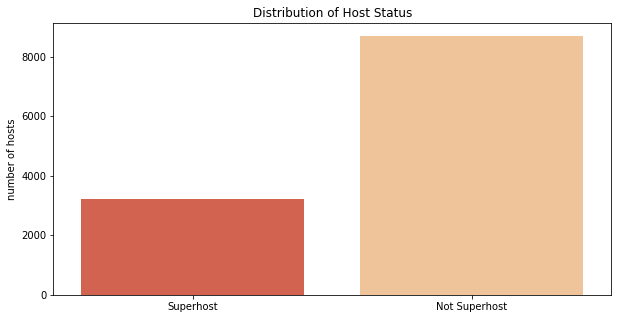

The number of Superhosts: 3224
The number of typical hosts: 8693


In [8]:
host_status = listings["host_is_superhost"]

f, axes = plt.subplots(figsize=(10,5))
ax = sns.countplot(x=host_status, palette="OrRd_r")
ax.set(title="Distribution of Host Status", \
       xlabel="", ylabel="number of hosts")
ax.set_xticklabels(["Superhost", "Not Superhost"])
plt.show()

print("The number of Superhosts: %d" \
      % len(listings[host_status == "t"]))
print("The number of typical hosts: %d" \
      % len(listings[host_status == "f"]))

Host status is actually expressed by a string *"t"* or *"f"*. We convert these to boolean by using the `apply` function. At the same time, the two NaNs are converted to a False – this is because we'd expect a host to be more likely to be a host than a Superhost given the statistics.

In [9]:
superhost = listings["host_is_superhost"]
superhost = superhost.apply(lambda row: 1 if row=="t" else 0)
listings["host_is_superhost"] = superhost

print("The number of NaNs after conversion: %d" \
      % len(listings[listings["host_is_superhost"].isna()]))

The number of NaNs after conversion: 0


The `host_verifications` lists the verification methods performed by the host to prove online identity. An example would be *email* verification, wherein a host receives an email from Airbnb to confirm that the email is valid. Another would be *phone* verification, wherein Airbnb calls the phone number given and, if answered, will confirm that the phone number is indeed the host's. The more verifications a host undergoes, the more the host will appear trustworthy to a prospect guest.

This feature is meant to be a list of the verifications provided, but Pandas treated this column as a string. Since these entries are formatted as a list by having elements enclosed in a pair of brackets (and each element separated by comma), the entries can be interpreted as lists by associating Python's `eval` function with Pandas' `apply`. We then count the number of elements per entry and plug the totals into a new feature called `host_verifications_count`.

The heads of the original `host_verifications` feature and the newly created `host_verifications_count` are shown below.

In [10]:
verifications = listings["host_verifications"]

verifications = verifications.apply(lambda row: eval(row) \
                                    if row != "None" else [])
verifications = verifications.apply(lambda row: len(row))

listings["host_verifications_count"] = verifications

display(listings[["host_verifications_count", \
                  "host_verifications"]].head())

,host_verifications_count,host_verifications
0,5,"['email', 'phone', 'facebook', 'reviews', 'kba']"
1,5,"['email', 'phone', 'facebook', 'reviews', 'kba']"
2,4,"['email', 'phone', 'reviews', 'kba']"
3,6,"['email', 'phone', 'reviews', 'jumio', 'govern..."
4,8,"['email', 'phone', 'reviews', 'jumio', 'offlin..."


The table showing distribution of hosts according to the `host_verifications_count` tells us that there are a maximum of 13 verifications. Only four hosts went through all of them. There are also six hosts that have listings that have not performed any verification.

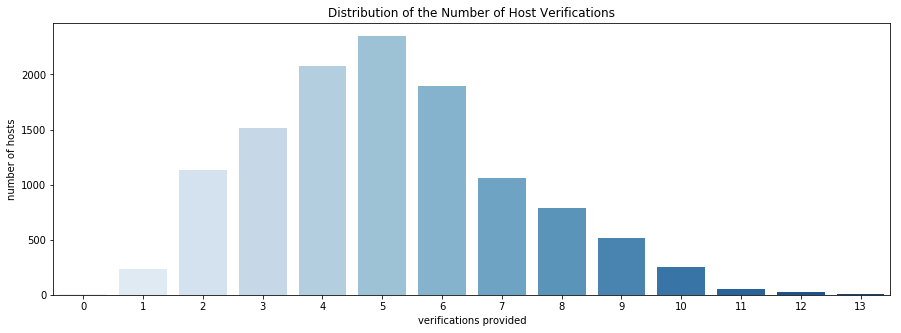

The no. of hosts that didn't undergo any verification: 6
The no. of hosts that underwent 13 verifications: 4


In [11]:
counts = listings["host_verifications_count"]

f, axes = plt.subplots(figsize=(15,5))
ax = sns.countplot(x=counts, palette="Blues")
ax.set(title="Distribution of the Number of Host Verifications", \
       xlabel="verifications provided", ylabel="number of hosts")
plt.show()

print("The no. of hosts that didn't undergo any verification: %d" \
      % len(listings[counts == 0]))
print("The no. of hosts that underwent 13 verifications: %d" \
      % len(listings[counts == 13]))

Although a host can undergo all the verifications stated above, it does not mean a host's identity is genuine. Providing identification does not mean that a host is *verified*, per Airbnb's standards. In 2013, Airbnb rolled out a tool that distinguished a host with a *verified* badge on their profile if the host has proven that his or her online identity matches their *offline* identification. The following steps listed on Airbnb's press release described the verification process:

1. Confirm their established online identity (through pre-existing Airbnb reviews, LinkedIn, or Facebook);
2. Provide proof of their offline identity (by either confirming historical personal information or by scanning their photo ID); and
3. The two names (online and offline) must match.

This verifcation process is not required, although it seems likely that it heightens perceived trustworthiness. The `host_identity_verified` distribution table below shows that there are actually only several hosts that are verified than there are unverified ones.

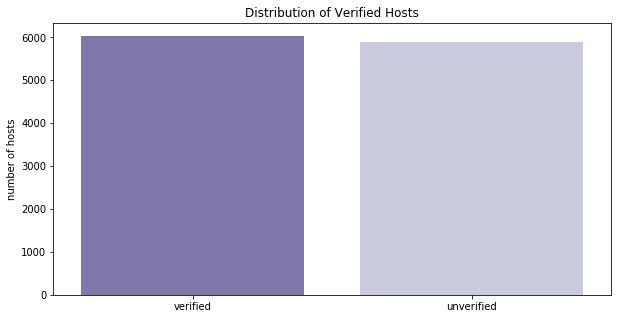

The number of verified hosts: 6032
The number of unverified hosts: 5885


In [12]:
verified = listings["host_identity_verified"]

f, axes = plt.subplots(figsize=(10,5))
ax = sns.countplot(x=verified, palette="Purples_r")
ax.set(title="Distribution of Verified Hosts", \
       xlabel="", ylabel="number of hosts")
ax.set_xticklabels(["verified", "unverified"])
plt.show()

print("The number of verified hosts: %d" \
      % len(listings[verified == "t"]))
print("The number of unverified hosts: %d" \
      % len(listings[verified == "f"]))

Again, this feature is denoted by a string *"t"* or a string *"f"*. We convert this column into boolean entries.

In [13]:
verified = verified.apply(lambda row: \
                          1 if row=="t" else 0)
listings["host_identity_verified"] = verified

### Listings Features Regarding Property ###
The `listings` dataset has multiple columns describing the nature of the properties themselves. We'll begin with the three categorical features: the `property_type`, `room_type`, and `cancellation_policy`. Below are their unique values. Note that there are no NaN entries for these.

In [14]:
print("Unique 'property_type' values:\n", \
      listings["property_type"].unique(), "\n")
print("Unique 'room_type' values:\n", \
      listings["room_type"].unique(), "\n")
print("Unique 'cancellation_policy' values:\n", \
      listings["cancellation_policy"].unique())

Unique 'property_type' values:
 ['House' 'Guesthouse' 'Apartment' 'Guest suite' 'Condominium' 'Townhouse'
 'Bungalow' 'Loft' 'Bed and breakfast' 'Other' 'Cabin' 'Cottage'
 'Campsite' 'Tiny house' 'Tent' 'Villa' 'Camper/RV' 'Nature lodge'
 'Chalet' 'Farm stay' 'Boat' 'Serviced apartment' 'Boutique hotel' 'Tipi'
 'Hostel' 'Treehouse' 'Barn' 'Aparthotel' 'Earth house' 'Yurt' 'Houseboat'
 'Resort' 'Dome house' 'Hotel'] 

Unique 'room_type' values:
 ['Entire home/apt' 'Private room' 'Shared room'] 

Unique 'cancellation_policy' values:
 ['strict_14_with_grace_period' 'moderate' 'flexible' 'super_strict_30'
 'super_strict_60']


There are too many categorizations for `property_type`. However, the distribution below shows that we can actually re-classify to just three types by bundling:
1. House
2. Apartment
3. Others

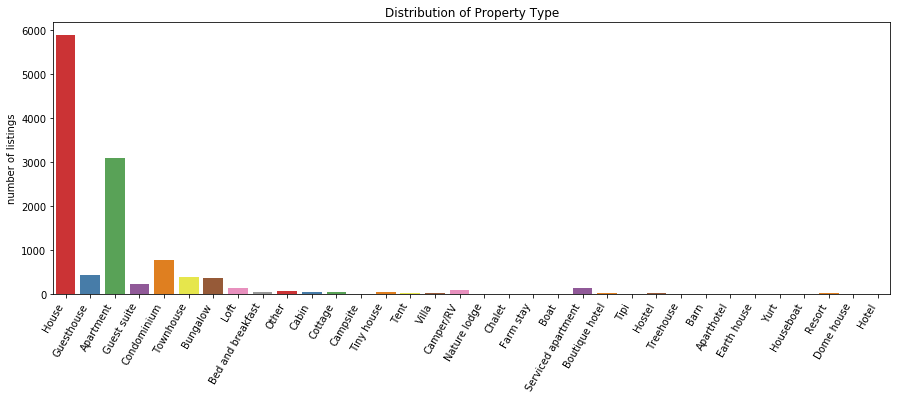

In [15]:
property_type = listings["property_type"]

f, axes = plt.subplots(figsize=(15,5))
ax = sns.countplot(x=property_type, palette="Set1")
ax.set(title="Distribution of Property Type", \
       xlabel="", ylabel="number of listings")
ax.set_xticklabels(labels=property_type.unique(), \
                   rotation=60, ha="right")
plt.show()

We use the `simplify` condition below to keep only the `House` and `Apartment` entries while the rest are converted to `Others`. To compare, the head of the `property_type` and the newly generated `property_type (simple)` are shown.

In [16]:
simplify = lambda row: "Other" if (row != "House") \
            and (row != "Apartment") else row

listings["property_type (simple)"] = property_type.apply(simplify)

display(listings[["property_type",
                  "property_type (simple)"]].head(15))

,property_type,property_type (simple)
0,House,House
1,House,House
2,Guesthouse,Other
3,House,House
4,Apartment,Apartment
5,Guesthouse,Other
6,Guest suite,Other
7,House,House
8,House,House
9,House,House


The `property_type (simple)`, `room_type`, and `cancellation_policy` have minimal categories yet succinctly describe the entries accordingly. Their distributions are below.

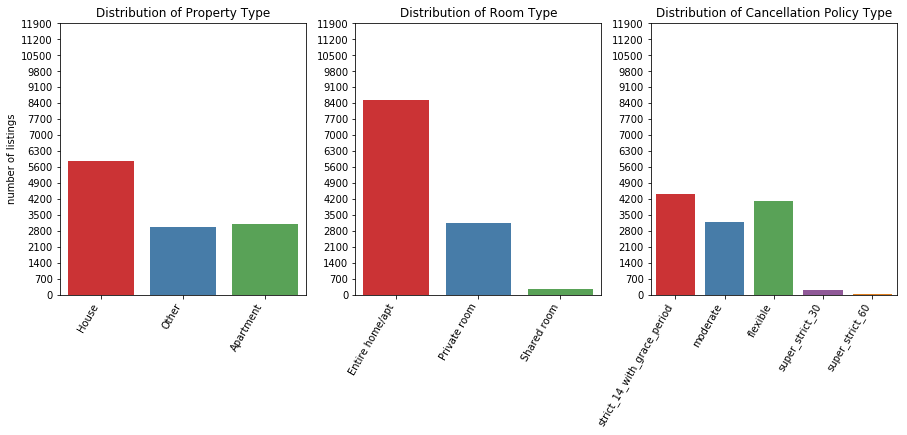

In [17]:
count = len(listings)
ticks = [idx for idx in range(0, count, 700)]

property_type = listings["property_type (simple)"]
room_type = listings["room_type"]
bed_type = listings["bed_type"]
cancellation = listings["cancellation_policy"]

f, axes = plt.subplots(1, 3, figsize=(15,5))

ax = sns.countplot(x=property_type, palette="Set1", \
                   ax=axes[0])
ax.set(title="Distribution of Property Type", \
       xlabel="", ylabel="number of listings", \
       ylim=[0,count], yticks=ticks)
ax.set_xticklabels(labels=property_type.unique(), \
                   rotation=60, ha="right")

ax = sns.countplot(x=room_type, palette="Set1", \
                   ax=axes[1])
ax.set(title="Distribution of Room Type", \
       xlabel="", ylabel="", \
       ylim=[0,count], yticks=ticks)
ax.set_xticklabels(labels=room_type.unique(), \
                   rotation=60, ha="right")

ax = sns.countplot(x=cancellation, palette="Set1", \
                   ax=axes[2])
ax.set(title="Distribution of Cancellation Policy Type", \
       xlabel="", ylabel="", \
       ylim=[0,count], yticks=ticks)
ax.set_xticklabels(labels=cancellation.unique(), \
                   rotation=60, ha="right")

plt.show()

### Listings Features Regarding Amenities ###
The `amenities` column of the `listings` dataset lists all the attributes a host claims a property has. This includes *TV*, *Wi-Fi*, or *hair dryer*. They could also be descriptions of the listing, including *family-friendly*, *24-hour check-in*, or if *pets* are allowed.

The entries to this column are elements enclosed in brackets but since curly brackets are used, Pandas interpreted this column as of the string datatype. So for every entry, the brackets are removed by slicing, and each row is split by comma. The `amenities_dict` is a Pythonic `defaultdict` that was used to tally each of the attribute entry and see how many listings made use of the attribute.

There are a total of 193 amenities counted. The percentage of listings that has a given amenity is shown below.

In [18]:
amenities_dict = defaultdict(int)

amenities = listings["amenities"].apply(lambda row: row[1:-1])
amenities = amenities.str.split(",")

for idx in range(len(listings)):
    for amenity in amenities.loc[idx]:
        amenities_dict[amenity] +=1

amenities_sorted = OrderedDict(sorted(amenities_dict.items(), \
                               key=lambda x: x[1], reverse=True))

amenities_tally = pd.DataFrame.from_dict(amenities_sorted, \
                                         orient="index")
amenities_tally.columns = ["Count of Amenity"]
amenities_tally["Percent"] = (amenities_tally["Count of Amenity"] \
                                  / len(listings))*100

print("Number of amenities available: %d" \
      % len(amenities_tally))
display(amenities_tally)

Number of amenities available: 193


,Count of Amenity,Percent
"""Air conditioning""",11638,97.642420
Wifi,11429,95.888917
Heating,11234,94.252874
Kitchen,11118,93.279638
Essentials,10840,90.947227
"""Smoke detector""",10619,89.093045
"""Free parking on premises""",9910,83.144559
TV,9747,81.776995
Washer,9671,81.139357
Dryer,9617,80.686299


Given that Austin is known for dry heat, almost all the listings are shown to have air-conditioning. The same is true for Wi-Fi and/or Internet. These are almost standard features that would not be helpful to our model because they are not distinct.

The following amenities are chosen because they have varying distributions that do not represent *all* or *none* of the listings:

1. **Private Entry**<br>
   The `Private entrance` is straightforward and doesn't have any variations in spelling or denotation.


2. **Family-friendly**<br>
   This is drawn from the `Family/kid friendly` amenity and is also straightforward.


3. **Pets OK**<br>
   There are four variations of this amenity. This feature will be True if any of the following appears in the listing's amenity: `Pets allowed`, `Cat(s)`, `Dog(s)`, or `Other Pet(s)`.


4. **Self Check-in**<br>
   This is True when the attribute `Self check-in` is among a listing's amenity.


5. **Balcony**<br>
   There are two variations of this amenity, either `Balcony, Patio` or simply `balcony`. So the requirement for this feature to be True is when a lower-cased *balcony* appears as its attribute.

Below is the head of the five newly created columns.

In [19]:
amenities = listings["amenities"]

private_entrance = amenities.apply(lambda row: 1 \
                                   if "Private entrance" in row \
                                   else 0)
family_friendly = amenities.apply(lambda row: 1 \
                                  if "Family/kid friendly" in row \
                                  else 0)
pets_allowed = amenities.apply(lambda row: 1 \
                               if ("Cat(s)" in row) \
                               or ("Dog(s)" in row) \
                               or ("Pet(s)" in row) \
                               or ("Pets allowed" in row) \
                               else 0)
self_checkin = amenities.apply(lambda row: 1 \
                               if "Self check-in" in row else 0)
balcony = amenities.apply(lambda row: 1 \
                          if "balcony" in row.lower() else 0)

listings["Private Entry"] = private_entrance
listings["Family-friendly"] = family_friendly
listings["Pets OK"] = pets_allowed
listings["Self Check-in"] = self_checkin
listings["Balcony"] = balcony

display(listings[["Private Entry", "Family-friendly", "Pets OK", \
                  "Self Check-in", "Balcony"]].head(15))

,Private Entry,Family-friendly,Pets OK,Self Check-in,Balcony
0,1,1,1,1,0
1,0,1,1,0,0
2,1,1,1,0,1
3,0,1,1,0,0
4,0,0,1,0,0
5,1,1,1,1,1
6,0,0,0,0,0
7,1,1,1,0,1
8,0,0,1,0,0
9,1,1,1,1,1


The distribution for the five columns are shown below.

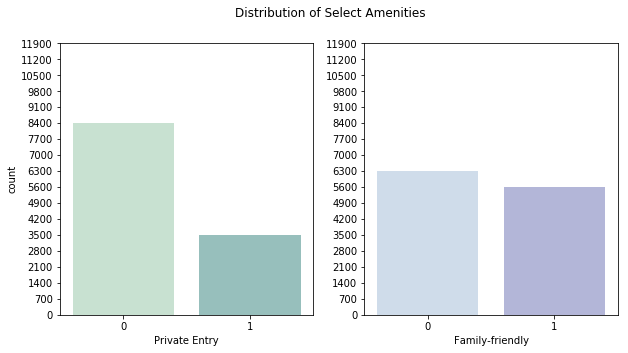

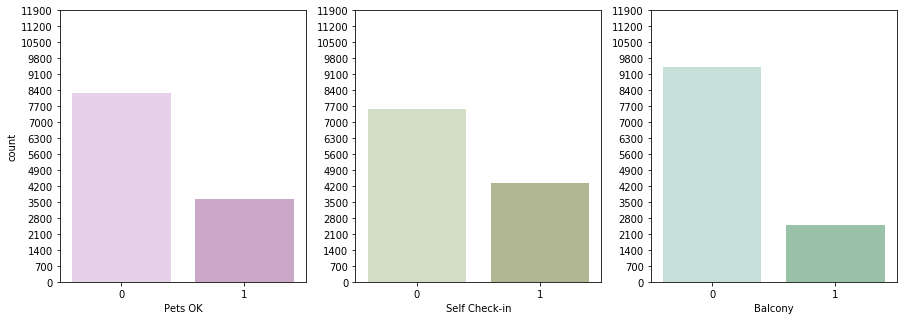

In [20]:
count = len(listings)
ticks = [idx for idx in range(0, count, 700)]

f, axes = plt.subplots(1, 2, figsize=(10,5))
f.suptitle("Distribution of Select Amenities")

ax = sns.countplot(x=listings["Private Entry"], palette \
                   =sns.cubehelix_palette(start=4, rot=-.75), \
                   ax=axes[0])
ax.set(ylim=[0,count], yticks=ticks)
ax = sns.countplot(x=listings["Family-friendly"], palette \
                   =sns.cubehelix_palette(start=4, rot=-.50), \
                   ax=axes[1])
ax.set(ylabel="", ylim=[0,count], yticks=ticks)

f, axes = plt.subplots(1, 3, figsize=(15,5))

ax = sns.countplot(x=listings["Pets OK"], palette \
                   =sns.cubehelix_palette(start=4, rot=-.25), \
                   ax=axes[0])
ax.set(ylim=[0,count], yticks=ticks)
ax = sns.countplot(x=listings["Self Check-in"], palette \
                   =sns.cubehelix_palette(start=4, rot=.25), \
                   ax=axes[1])
ax.set(ylabel="", ylim=[0,count], yticks=ticks)
ax = sns.countplot(x=listings["Balcony"], palette \
                   =sns.cubehelix_palette(start=4, rot=.5), \
                   ax=axes[2])
ax.set(ylabel="", ylim=[0,count], yticks=ticks)

plt.show()

### Continuous Listings Features ###
There are five candidate features for our model that are not discrete: `accommodates`, `guests_included`, `extra_people`, `minimum_nights`, `number_of_reviews`.

The `accommodates` feature is the total number of people the listing can hold. This can also be referred to as the capacity of the property.

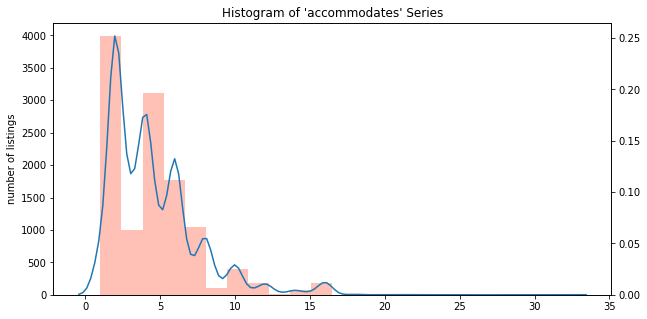

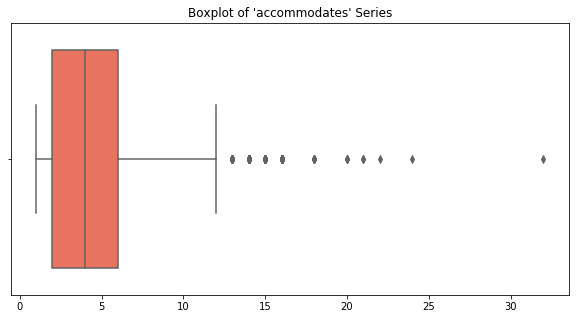

,accommodates
6524,32
8328,24
11446,22
7909,21
8329,21
10171,20
9914,20
11105,20
7910,18
6781,18


In [21]:
accommodates = listings["accommodates"]

f, axes = plt.subplots(figsize=(10,5))
ax = sns.distplot(a=accommodates, \
                  bins=len(accommodates.unique()),
                  kde=False, color="tomato")
ax.set(title="Histogram of 'accommodates' Series", \
       ylabel="number of listings", xlabel="")

plt.twinx()
ax = sns.kdeplot(accommodates)
ax.get_legend().remove()

f, axes = plt.subplots(figsize=(10,5))
ax = sns.boxplot(x=accommodates, color="tomato")
ax.set(title="Boxplot of 'accommodates' Series", \
       xlabel="")

plt.show()

sorted_accommodates = listings.sort_values("accommodates", \
                                           ascending=False)
display(sorted_accommodates[["accommodates"]].head(10))

The boxplot tells us that there are too many outliers spread out beyond the 75th percentile. To simplify this feature, anything above 20 is truncated to `20`.

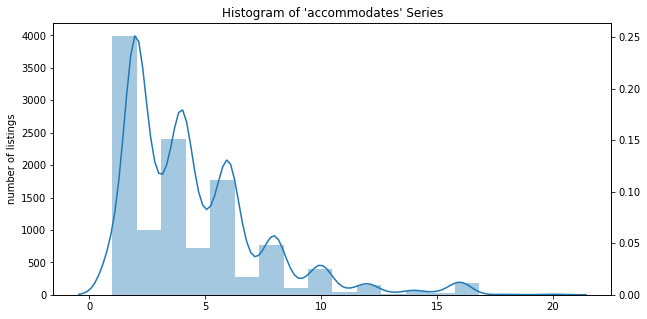

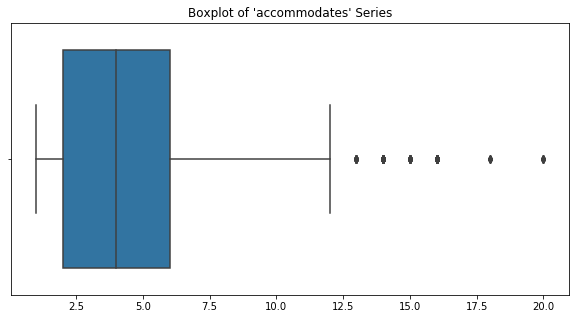

In [22]:
listings.loc[listings["accommodates"] > 20, \
             "accommodates"] = 20

accommodates = listings["accommodates"]

f, axes = plt.subplots(figsize=(10,5))
ax = sns.distplot(a=accommodates, \
                  bins=len(accommodates.unique()),
                  kde=False)
ax.set(title="Histogram of 'accommodates' Series", \
       ylabel="number of listings", xlabel="")

plt.twinx()
ax = sns.kdeplot(accommodates)
ax.get_legend().remove()

f, axes = plt.subplots(figsize=(10,5))
ax = sns.boxplot(x=accommodates)
ax.set(title="Boxplot of 'accommodates' Series", \
       xlabel="")

plt.show()

The `guests_included` column identifies how many people are include in the quoted nighly rate.

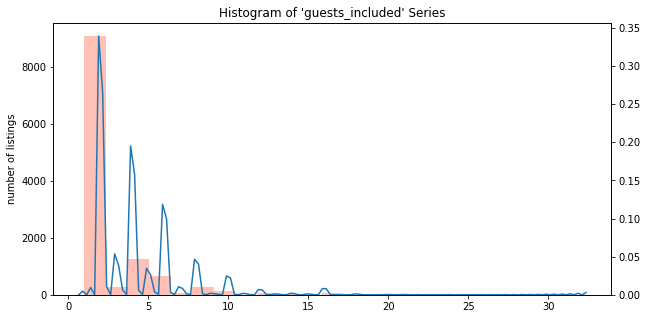

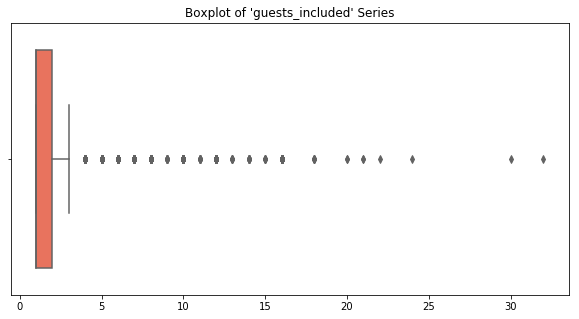

,guests_included
6524,32
11105,30
8328,24
11446,22
8329,21
7909,21
10171,20
9914,20
10170,18
6781,18


In [23]:
guests_included = listings["guests_included"]

f, axes = plt.subplots(figsize=(10,5))
ax = sns.distplot(a=guests_included, \
                  bins=len(guests_included.unique()),
                  kde=False, color="tomato")
ax.set(title="Histogram of 'guests_included' Series", \
       ylabel="number of listings", xlabel="")

plt.twinx()
ax = sns.kdeplot(guests_included)
ax.get_legend().remove()

f, axes = plt.subplots(figsize=(10,5))
ax = sns.boxplot(x=guests_included, color="tomato")
ax.set(title="Boxplot of 'guests_included' Series", \
       xlabel="")

plt.show()

sorted_guests = listings.sort_values("guests_included", \
                                           ascending=False)
display(sorted_guests[["guests_included"]].head(10))

Again, there are numerous outliers so the values above 20 are truncated to `20`.

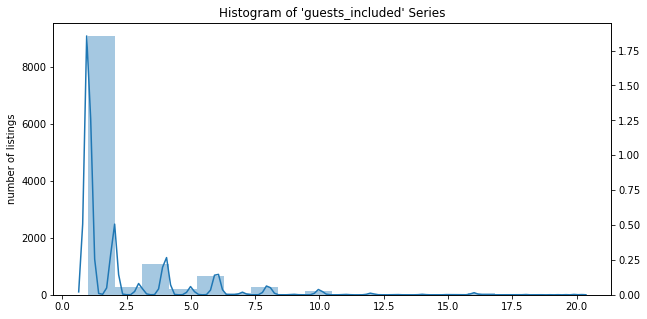

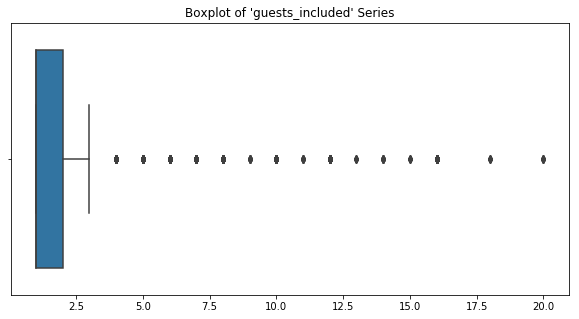

In [24]:
listings.loc[listings["guests_included"] > 20, \
             "guests_included"] = 20

guests_included = listings["guests_included"]

f, axes = plt.subplots(figsize=(10,5))
ax = sns.distplot(a=guests_included, \
                  bins=len(guests_included.unique()),
                  kde=False)
ax.set(title="Histogram of 'guests_included' Series", \
       ylabel="number of listings", xlabel="")

plt.twinx()
ax = sns.kdeplot(guests_included)
ax.get_legend().remove()

f, axes = plt.subplots(figsize=(10,5))
ax = sns.boxplot(x=guests_included)
ax.set(title="Boxplot of 'guests_included' Series", \
       xlabel="")

plt.show()

The `extra_people` is the additional cost per night for every additional guest beyond the `guests_included` of a listing.

The `listings` dataset denotes entries to this column in a monetary format. So a hunder dollars is expressed as `$100.00`, therefore a string. The dollar sign is then removed from each entry before the entire column is converted to float using the `astype` function. NaNs are filled with zeroes since this means there just isn't an extra charge for additional guests.

In [25]:
extra_people = listings["extra_people"].str.replace("$", "")
extra_people = extra_people.astype(float)
listings["extra_people"] = extra_people.fillna(0)

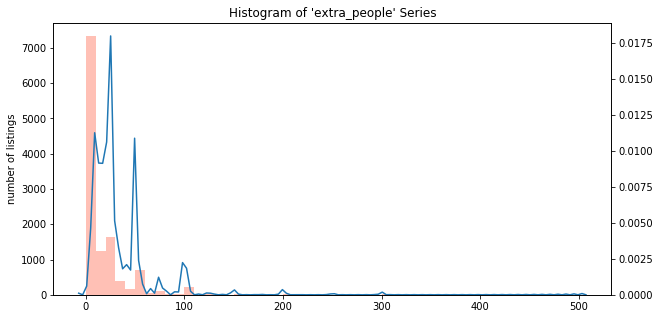

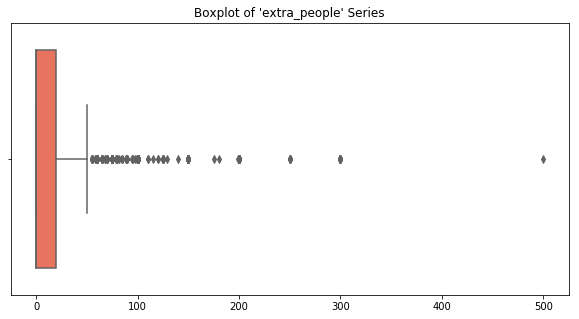

,extra_people
422,500.0
4731,300.0
2902,300.0
8707,300.0
5771,300.0
5281,300.0
6083,300.0
898,300.0
386,300.0
1073,300.0


In [26]:
extra_people = listings["extra_people"]

f, axes = plt.subplots(figsize=(10,5))
ax = sns.distplot(a=extra_people, kde=False, color="tomato")
ax.set(title="Histogram of 'extra_people' Series", \
       ylabel="number of listings", xlabel="")

plt.twinx()
ax = sns.kdeplot(extra_people)
ax.get_legend().remove()

f, axes = plt.subplots(figsize=(10,5))
ax = sns.boxplot(x=extra_people, color="tomato")
ax.set(title="Boxplot of 'extra_people' Series", \
       xlabel="")

plt.show()

sorted_extra = listings.sort_values("extra_people", \
                                    ascending=False)
display(sorted_extra[["extra_people"]].head(10))

There is an obvious outlier that requests $500 for an extra guest. This value is changed to match the next maximum value, `300`. This narrowed the boxplot a bit.

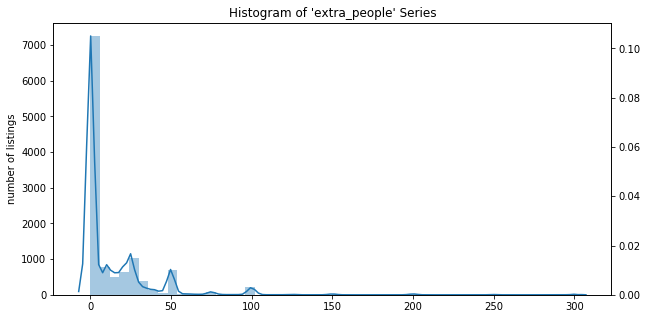

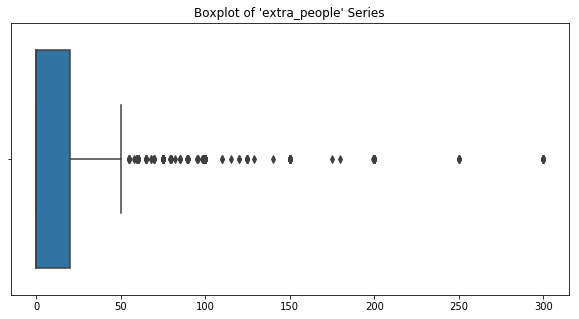

In [27]:
listings.loc[listings["extra_people"] > 300, \
             "extra_people"] = 300

extra_people = listings["extra_people"]

f, axes = plt.subplots(figsize=(10,5))
ax = sns.distplot(a=extra_people, kde=False)
ax.set(title="Histogram of 'extra_people' Series", \
       ylabel="number of listings", xlabel="")

plt.twinx()
ax = sns.kdeplot(extra_people)

ax.get_legend().remove()

f, axes = plt.subplots(figsize=(10,5))
ax = sns.boxplot(x=extra_people)
ax.set(title="Boxplot of 'extra_people' Series", \
       xlabel="")

plt.show()

Some listings do not allow for single-night stays and may require up to two or more nights, hence the `minimum_nights` feature.

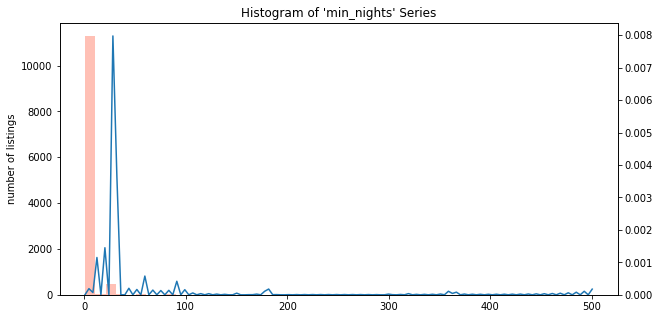

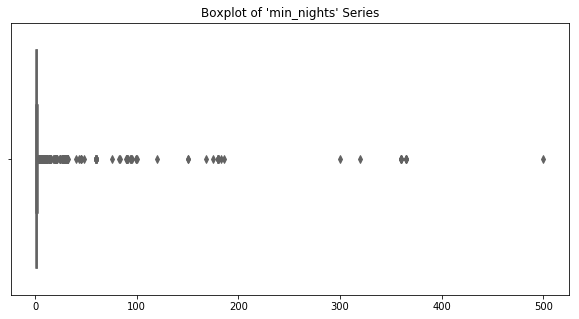

,minimum_nights
8607,500
8895,365
5356,365
9735,365
738,365
772,360
4865,360
1607,360
473,360
4862,360


In [28]:
min_nights = listings["minimum_nights"]

f, axes = plt.subplots(figsize=(10,5))
ax = sns.distplot(a=min_nights, kde=False, color="tomato")
ax.set(title="Histogram of 'min_nights' Series", \
       ylabel="number of listings", xlabel="")

plt.twinx()
ax = sns.kdeplot(min_nights)
ax.get_legend().remove()

f, axes = plt.subplots(figsize=(10,5))
ax = sns.boxplot(x=min_nights, color="tomato")
ax.set(title="Boxplot of 'min_nights' Series", \
       xlabel="")

plt.show()

sorted_min = listings.sort_values("minimum_nights", \
                                  ascending=False)
display(sorted_min[["minimum_nights"]].head(10))

From the plot above, it appears that most listings actually do not require minimums. Though there are entries that require a year's worth of stay to book, it can be said that a week is enough to be considered *long-term* given that Airbnb is primarily a service for a few days' stay.

Therefore the listings that require more than 7 days for their `minimum_nights` are truncated to `7`.

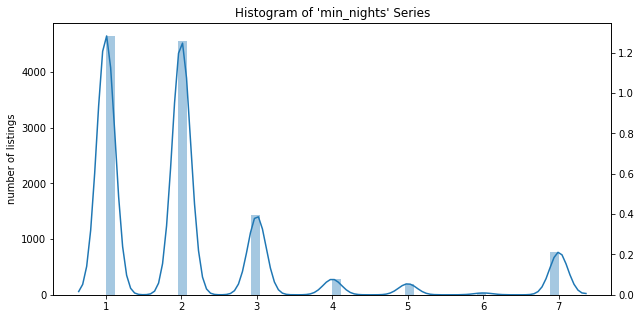

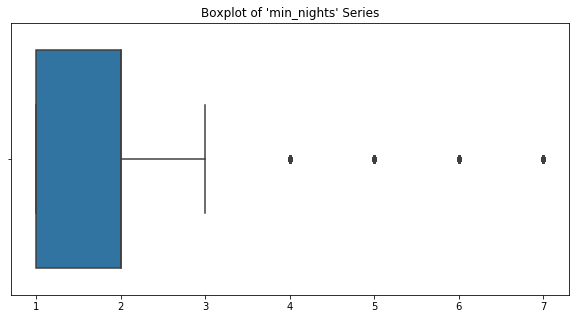

In [29]:
listings.loc[listings["minimum_nights"] > 7, \
             "minimum_nights"] = 7

min_nights = listings["minimum_nights"]

f, axes = plt.subplots(figsize=(10,5))
ax = sns.distplot(a=min_nights, kde=False)
ax.set(title="Histogram of 'min_nights' Series", \
       ylabel="number of listings", xlabel="")

plt.twinx()
ax = sns.kdeplot(min_nights)
ax.get_legend().remove()

f, axes = plt.subplots(figsize=(10,5))
ax = sns.boxplot(x=min_nights)
ax.set(title="Boxplot of 'min_nights' Series", \
       xlabel="")

plt.show()

The `number_of_reviews` may indicate to some degree the popularity of the listing. This does not reflect good or bad reviews, however.

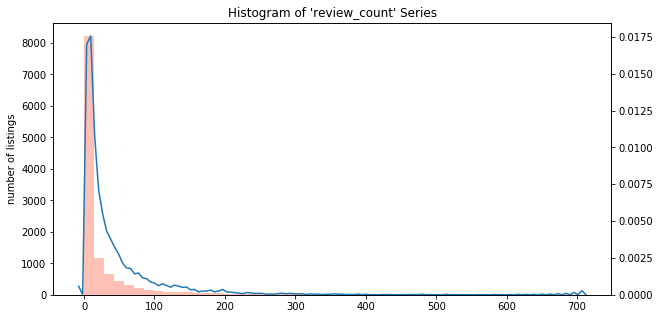

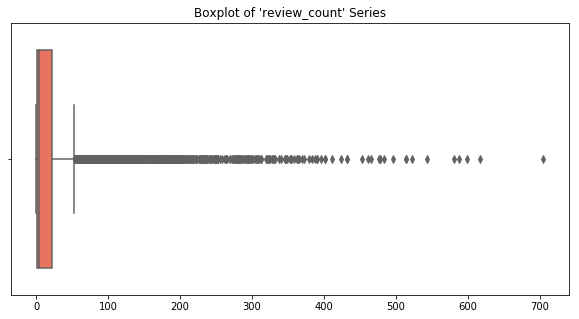

,number_of_reviews
758,705
677,617
116,599
834,588
678,581
393,543
770,523
1876,514
28,514
2308,496


In [30]:
review_count = listings["number_of_reviews"]

f, axes = plt.subplots(figsize=(10,5))
ax = sns.distplot(a=review_count, kde=False, color="tomato")
ax.set(title="Histogram of 'review_count' Series", \
       ylabel="number of listings", xlabel="")

plt.twinx()
ax = sns.kdeplot(review_count)
ax.get_legend().remove()

f, axes = plt.subplots(figsize=(10,5))
ax = sns.boxplot(x=review_count, color="tomato")
ax.set(title="Boxplot of 'review_count' Series", \
       xlabel="")

plt.show()

sorted_review = listings.sort_values("number_of_reviews", \
                                    ascending=False)
display(sorted_review[["number_of_reviews"]].head(10))

A listing with a hundred reviews or more can definitely be said to be popular, and are then truncated to a value of `100`.

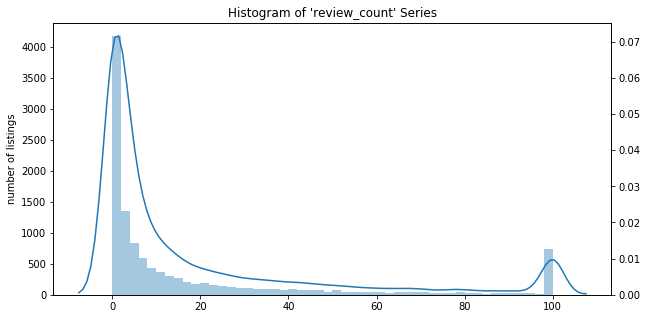

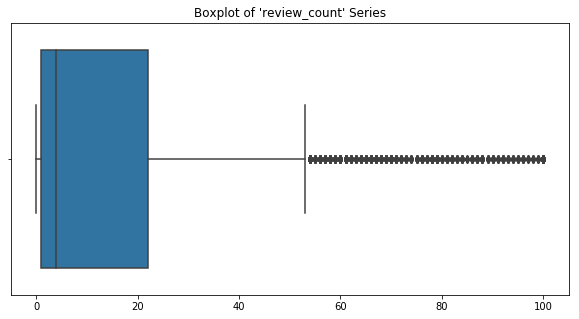

In [31]:
listings.loc[listings["number_of_reviews"] > 100, \
             "number_of_reviews"] = 100

review_count = listings["number_of_reviews"]

f, axes = plt.subplots(figsize=(10,5))
ax = sns.distplot(a=review_count, kde=False)
ax.set(title="Histogram of 'review_count' Series", \
       ylabel="number of listings", xlabel="")

plt.twinx()
ax = sns.kdeplot(review_count)
ax.get_legend().remove()

f, axes = plt.subplots(figsize=(10,5))
ax = sns.boxplot(x=review_count)
ax.set(title="Boxplot of 'review_count' Series", \
       xlabel="")

plt.show()

### Sub Dataframe: Crimes ###
The `crimes` dataset contains all the reported crimes in Austin, TX that occurred in 2018, the same timeframe as the `listings` dataset. A preview of each of columns are below.

In [32]:
crimes = pd.read_csv("Crime_Reports_2018.csv")
for i in range(0, len(crimes.columns), 10):
    columns = crimes.columns[i:i+10]
    display(crimes[columns].head())

,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time
0,20185030475,CRED CARD ABUSE - OTHER,1106,N,08/07/2018 05:45:00 AM,08/07/2018,545,08/08/2018 05:13:00 PM,08/08/2018,1713
1,20185040446,ASSAULT BY THREAT,901,N,10/09/2018 01:30:00 PM,10/09/2018,1330,10/10/2018 04:50:00 PM,10/10/2018,1650
2,20182741878,POSS OF DRUG PARAPHERNALIA,1818,N,10/01/2018 11:51:00 PM,10/01/2018,2351,10/01/2018 11:51:00 PM,10/01/2018,2351
3,20182031524,DOC DISPLAY GUN/DEADLY PUB PLC,2409,N,07/22/2018 09:12:00 PM,07/22/2018,2112,07/22/2018 10:44:00 PM,07/22/2018,2244
4,20182220769,PUBLIC INTOXICATION,2300,N,08/10/2018 12:14:00 PM,08/10/2018,1214,08/10/2018 12:14:00 PM,08/10/2018,1214


,Location Type,Address,Zip Code,Council District,APD Sector,APD District,PRA,Census Tract,Clearance Status,Clearance Date
0,DEPARTMENT / DISCOUNT STORE,710 E BEN WHITE BLVD SVRD WB,78704.0,3.0,DA,2,480.0,23.08,N,08/09/2018
1,RESIDENCE / HOME,4117 BAYBERRY DR,78759.0,10.0,BA,4,231.0,17.07,N,10/11/2018
2,HOTEL / MOTEL / ETC.,10711 RESEARCH BLVD SVRD NB,78759.0,7.0,AD,1,215.0,17.53,N,10/07/2018
3,PARKING LOTS / GARAGE,2829 S LAKELINE BLVD,78613.0,6.0,AD,4,118.0,203.18,NaN,NaN
4,STREETS / HWY / ROAD / ALLEY,1600 TINNIN FORD RD,78741.0,3.0,HE,2,441.0,23.04,C,08/10/2018


,UCR Category,Category Description,X-coordinate,Y-coordinate,Latitude,Longitude,Location
0,NaN,NaN,3110718.0,3110718.0,30.219079,-97.755505,"(30.21907896, -97.75550548)"
1,NaN,NaN,3109730.0,3109730.0,30.370219,-97.754599,"(30.37021903, -97.75459935)"
2,NaN,NaN,3112827.0,3112827.0,30.398291,-97.744022,"(30.39829057, -97.74402237)"
3,NaN,NaN,3092093.0,3092093.0,30.475932,-97.807773,"(30.47593212, -97.80777293)"
4,NaN,NaN,3119686.0,3119686.0,30.241188,-97.726508,"(30.24118778, -97.72650789)"


The `crimes_info` is a dictionary depicting the number of missing entries, as well as the percentage of NaN entries, of every column. This is then turned into a dataframe to make the statistics easily readable.

In [33]:
crimes_info = {"series": crimes.columns, \
               "entry count": [crimes[column].count()
                               for column in crimes.columns], \
               "NaN count": [crimes[column].isna().sum() \
                             for column in crimes.columns], \
               "percent of NaN (%)": [(crimes[column].isna().sum() \
                                       / len(crimes))*100 \
                                       for column in crimes.columns]}

crimes_info = pd.DataFrame(crimes_info).set_index("series")
for i in range(0, len(crimes_info), 30):
    display(crimes_info.iloc[i:i+30])

,entry count,NaN count,percent of NaN (%)
series,,,
Incident Number,102663,0,0.000000
Highest Offense Description,102663,0,0.000000
Highest Offense Code,102663,0,0.000000
Family Violence,102663,0,0.000000
Occurred Date Time,102663,0,0.000000
Occurred Date,102663,0,0.000000
Occurred Time,102663,0,0.000000
Report Date Time,102663,0,0.000000
Report Date,102663,0,0.000000


The `Zip Code` is what we'll use to relate the relevant `crimes` features to the `listings` dataframe. In all, there are 948 missing entries for this column, or about 1%. Out of these, there are 181 entries that has valid entries for `Location`, which is a combination of `Latitude` and `Longitude`.

In [34]:
without_zip = crimes["Zip Code"].isna()
with_location = crimes["Location"].isna() == False

no_zip = crimes[without_zip & with_location].index.tolist()

print(len(no_zip))

181


Again, we'll make use of the MapQuest API in order to give these 181 entries their correct `Zip Code`.

In [35]:
zipcodes = {}
for idx in no_zip[0:0]:
    lat = crimes.loc[idx]["Latitude"]
    lat = str(lat)
    
    long = crimes.loc[idx]["Longitude"]
    long = str(long)
    
    url = API + API_KEY + r"&location=" + lat + r"," + long + \
           r"&outFormat=json&thumbMaps=false"
    r = requests.get(url)

    API_zip = r.json()["results"][0]["locations"][0]["postalCode"]
    API_zip = re.findall("^\d*", API_zip)[0]
    if API_zip == "":
        continue

    zipcodes[idx] = API_zip

zipcodes={1748: '78704', 1773: '78754', 2410: '78753', 2986: '78723', 3345: '78702', 3953: '78723', 4304: '78741', 4953: '78756', 6226: '78701', 7042: '78705', 7401: '78701', 7516: '78613', 8165: '78705', 8629: '78750', 8777: '78746', 10658: '78744', 11230: '78705', 11506: '78748', 11557: '78722', 11729: '78702', 12707: '78750', 13086: '78731', 13706: '78752', 13783: '78719', 14352: '78754', 15740: '78660', 17782: '78735', 20752: '78741', 20857: '78759', 22922: '78750', 23455: '78704', 24199: '78741', 24973: '78721', 24993: '78746', 25490: '78610', 27035: '78701', 27445: '78752', 27569: '78754', 28327: '78702', 28432: '78753', 29120: '78724', 29351: '78735', 29382: '78751', 29386: '78750', 29394: '78702', 29421: '78758', 29506: '78753', 29542: '78750', 29777: '78702', 29874: '78741', 29924: '78731', 30056: '78753', 30374: '78723', 30519: '78752', 30655: '78701', 30677: '78704', 30792: '78753', 31172: '78704', 31631: '78701', 31725: '78704', 31856: '78748', 32061: '78758', 32161: '78753', 32208: '78759', 32252: '78747', 32379: '78704', 32420: '78744', 32445: '78753', 32469: '78753', 32680: '78723', 32807: '78702', 32953: '78753', 32962: '78703', 33063: '78746', 33147: '78704', 33329: '78759', 33350: '78701', 33354: '78723', 33527: '78752', 33818: '78741', 33956: '78702', 34514: '78704', 36835: '78753', 39038: '78704', 39198: '78753', 39720: '78717', 40172: '78724', 41587: '78741', 43254: '78723', 43828: '78702', 44547: '78745', 47254: '78744', 47914: '78704', 48009: '78727', 48556: '78745', 48969: '78758', 49116: '78701', 49269: '78759', 49586: '78723', 50695: '78753', 51309: '78753', 52087: '78748', 52251: '78758', 52383: '78744', 52782: '78750', 52845: '78705', 53932: '78729', 54143: '78702', 54150: '78758', 56548: '78745', 56828: '78731', 58528: '78617', 58908: '78748', 59362: '78702', 60103: '78758', 60436: '78753', 60808: '78741', 61935: '78746', 63641: '78753', 63952: '78741', 64205: '78752', 64783: '78741', 64816: '78721', 64822: '78704', 65731: '78704', 66307: '78741', 67074: '78741', 67271: '78753', 68903: '78702', 69036: '78723', 69193: '78759', 69855: '78759', 71070: '78729', 71779: '78741', 72743: '78723', 73099: '78702', 73371: '78753', 74562: '78757', 75581: '78729', 77431: '78748', 78297: '78704', 78688: '78704', 78892: '78704', 79698: '78753', 80335: '78729', 82127: '78753', 83044: '78744', 84205: '78704', 85690: '78613', 86491: '78739', 88418: '78746', 89756: '78757', 89980: '78729', 90114: '78704', 90563: '78704', 90770: '78729', 90773: '78704', 91485: '78751', 91748: '78746', 92271: '78753', 92566: '78729', 92665: '78723', 93374: '78723', 93429: '78753', 94487: '78729', 94670: '78704', 94752: '78750', 95890: '78704', 95963: '78741', 96192: '78759', 96276: '78704', 96852: '78735', 98604: '78759', 98858: '78726', 98954: '78753', 99183: '78660', 100867: '78741', 101025: '78704', 101183: '78617', 102593: '78660'}
print(zipcodes)

{1748: '78704', 1773: '78754', 2410: '78753', 2986: '78723', 3345: '78702', 3953: '78723', 4304: '78741', 4953: '78756', 6226: '78701', 7042: '78705', 7401: '78701', 7516: '78613', 8165: '78705', 8629: '78750', 8777: '78746', 10658: '78744', 11230: '78705', 11506: '78748', 11557: '78722', 11729: '78702', 12707: '78750', 13086: '78731', 13706: '78752', 13783: '78719', 14352: '78754', 15740: '78660', 17782: '78735', 20752: '78741', 20857: '78759', 22922: '78750', 23455: '78704', 24199: '78741', 24973: '78721', 24993: '78746', 25490: '78610', 27035: '78701', 27445: '78752', 27569: '78754', 28327: '78702', 28432: '78753', 29120: '78724', 29351: '78735', 29382: '78751', 29386: '78750', 29394: '78702', 29421: '78758', 29506: '78753', 29542: '78750', 29777: '78702', 29874: '78741', 29924: '78731', 30056: '78753', 30374: '78723', 30519: '78752', 30655: '78701', 30677: '78704', 30792: '78753', 31172: '78704', 31631: '78701', 31725: '78704', 31856: '78748', 32061: '78758', 32161: '78753', 32208:

From 948, we've reduced the NaN count for `Zip Code` to just 768.

In [36]:
for idx in no_zip:
    crimes.loc[idx, "Zip Code"] = zipcodes.get(idx)

print("The number of NaNs for 'Zip Code': %d" % \
      len(crimes[crimes["Zip Code"].isna()]))

The number of NaNs for 'Zip Code': 768


Since reports that have unknown `Zip Code` are useless to our study because they will not be able to contribute to our Airbnb data, we'll proceed to drop them. We'll also convert the column from string to integers.

In [37]:
crimes = crimes.dropna(subset=["Zip Code"])

crimes["Zip Code"] = crimes["Zip Code"].astype(int)

From the `crimes` dataframe, the `crimes_per_zip` is generated by grouping entries by `Zip Code` and aggregating by count. This gives us an overall picture of the total number of crimes in a given area.

In [38]:
crimes_per_zip = crimes.groupby("Zip Code").count()[["Incident Number"]]
crimes_per_zip = crimes_per_zip.sort_values("Incident Number", \
                                            ascending=False)

crimes_per_zip.columns = ["Total No. of Crimes"]
crimes_per_zip = crimes_per_zip.reset_index()

display(crimes_per_zip.head(15))

,Zip Code,Total No. of Crimes
0,78741,8189
1,78753,7863
2,78758,7580
3,78701,7081
4,78704,6523
5,78745,6459
6,78744,5750
7,78723,5678
8,78702,4838
9,78752,3607


Crimes are categorized on a top-level according to the FBI designation mentioned in the [Datasets](#Datasets) section. However, only serious crimes have this `Category Description`. The `major_crimes` is a dataframe derived from a pivot_table that aggregated the number of reports by `Category Description` and indexed by `Zip Code`. The NaNs are rightly filled with zeroes.

In [39]:
major_crimes = crimes.pivot_table(index="Zip Code", \
                                  columns="Category Description", \
                                  values="Incident Number", \
                                  aggfunc="count")
major_crimes = major_crimes.reset_index()
major_crimes.columns.name = None

major_crimes = major_crimes.fillna(0)

display(major_crimes.head(15))

,Zip Code,Aggravated Assault,Auto Theft,Burglary,Murder,Rape,Robbery,Theft
0,78613,7.0,8.0,9.0,0.0,2.0,8.0,319.0
1,78617,24.0,18.0,52.0,2.0,6.0,5.0,120.0
2,78652,3.0,0.0,0.0,0.0,0.0,1.0,4.0
3,78653,5.0,6.0,6.0,0.0,0.0,1.0,39.0
4,78660,16.0,14.0,23.0,0.0,4.0,0.0,256.0
5,78664,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,78681,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,78701,118.0,84.0,82.0,0.0,53.0,77.0,1707.0
8,78702,106.0,120.0,211.0,1.0,28.0,72.0,1190.0
9,78703,5.0,49.0,66.0,0.0,7.0,5.0,563.0


The `crimes_per_zip` dataframe, which looks at the totals of *all* crimes, and the `major_crimes` dataframe, which details only *serious* crimes, are merged inclusively (outer-wise). The resulting dataframe is `crimes_clean` and its NaNs are filled with zeroes. This is because missing values occur when there is no crime report that exists.

In [40]:
crimes_clean = pd.merge(crimes_per_zip, major_crimes, \
                        how="outer", on="Zip Code")
crimes_clean = crimes_clean.fillna(0, axis=0)

display(crimes_clean.head(10))
display(crimes_clean.tail(10))

,Zip Code,Total No. of Crimes,Aggravated Assault,Auto Theft,Burglary,Murder,Rape,Robbery,Theft
0,78741,8189,206.0,210.0,350.0,2.0,83.0,137.0,1823.0
1,78753,7863,182.0,180.0,304.0,5.0,53.0,107.0,2053.0
2,78758,7580,164.0,182.0,384.0,4.0,68.0,104.0,1811.0
3,78701,7081,118.0,84.0,82.0,0.0,53.0,77.0,1707.0
4,78704,6523,96.0,196.0,300.0,2.0,35.0,42.0,1936.0
5,78745,6459,133.0,194.0,290.0,3.0,52.0,36.0,1436.0
6,78744,5750,160.0,153.0,234.0,3.0,39.0,45.0,1105.0
7,78723,5678,132.0,112.0,244.0,5.0,33.0,85.0,1303.0
8,78702,4838,106.0,120.0,211.0,1.0,28.0,72.0,1190.0
9,78752,3607,89.0,71.0,114.0,0.0,32.0,58.0,674.0


,Zip Code,Total No. of Crimes,Aggravated Assault,Auto Theft,Burglary,Murder,Rape,Robbery,Theft
44,78737,10,0.0,0.0,0.0,0.0,1.0,0.0,1.0
45,78732,10,0.0,0.0,0.0,0.0,1.0,0.0,2.0
46,78733,7,0.0,0.0,0.0,0.0,1.0,0.0,1.0
47,78681,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0
48,78610,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,78738,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,78664,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0
51,78641,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52,78734,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0
53,78612,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Putting It All Together ###
The unique values of the zip codes for the `listings` dataset are compared with the unique values of the zip codes for the `crime` dataset. By turning the lists into sets, what is present in one and not in the other can easily be determined.

We see that there are three zip codes that are in the Airbnb dataset that are *not* in the crime data. This is because the crime data focuses in Austin, TX alone, whereas the Airbnb dataset referred to Austin, TX in terms of both the city *and* a few of its neighboring sububrs that are most often associated with the Texan capital.

In [41]:
listings_zip = set(listings["zipcode"].unique())
crimes_zip = set(crimes_clean["Zip Code"].unique())

print("Zip codes present in Airbnb listings but not in crimes data: %s" %
      listings_zip.difference(crimes_zip))

Zip codes present in Airbnb listings but not in crimes data: {78619, 78620, 78669}


An interim dataframe `listings_clean` is created by merging the `listings` and the `crimes_clean` dataframes.

In [42]:
listings_clean = pd.merge(listings, crimes_clean, how="left", \
                          left_on="zipcode", right_on="Zip Code")

From the `listings_clean`, the final dataframe `df` is generated by filtering the 27 necessary features for our model.

A preview of `df` is below.

In [43]:
columns = ["id", "price", "zipcode", "host_is_superhost", \
           "host_verifications_count", "host_identity_verified", \
           "property_type (simple)", "room_type", "cancellation_policy", \
           "Private Entry", "Family-friendly", "Pets OK", \
           "Self Check-in", "Balcony", "accommodates", \
           "guests_included", "extra_people", "minimum_nights", \
           "number_of_reviews", "Total No. of Crimes", \
           "Aggravated Assault", "Auto Theft", "Burglary", \
           "Murder", "Rape", "Robbery", "Theft"]

df = listings_clean[columns]

for i in range(0, len(df.columns), 10):
    columns = df.columns[i:i+10]
    display(df[columns].head())

,id,price,zipcode,host_is_superhost,host_verifications_count,host_identity_verified,property_type (simple),room_type,cancellation_policy,Private Entry
0,2265,$225.00,78702,1,5,1,House,Entire home/apt,strict_14_with_grace_period,1
1,5245,$125.00,78702,1,5,1,House,Private room,strict_14_with_grace_period,0
2,5456,$95.00,78702,1,4,1,Other,Entire home/apt,strict_14_with_grace_period,1
3,5769,$40.00,78729,1,6,1,House,Private room,moderate,0
4,6413,$99.00,78704,0,8,0,Apartment,Entire home/apt,strict_14_with_grace_period,0


,Family-friendly,Pets OK,Self Check-in,Balcony,accommodates,guests_included,extra_people,minimum_nights,number_of_reviews,Total No. of Crimes
0,1,1,1,0,4,4,30.0,2,23,4838.0
1,1,1,0,0,2,2,25.0,2,9,4838.0
2,1,1,0,1,3,2,45.0,2,100,4838.0
3,1,1,0,0,2,2,0.0,1,100,1768.0
4,0,1,0,0,2,2,25.0,3,79,6523.0


,Aggravated Assault,Auto Theft,Burglary,Murder,Rape,Robbery,Theft
0,106.0,120.0,211.0,1.0,28.0,72.0,1190.0
1,106.0,120.0,211.0,1.0,28.0,72.0,1190.0
2,106.0,120.0,211.0,1.0,28.0,72.0,1190.0
3,30.0,45.0,56.0,1.0,7.0,10.0,475.0
4,96.0,196.0,300.0,2.0,35.0,42.0,1936.0


There are a total of 4 entries that have NaNs in any of the columns of `df`. These refer to Airbnb listings that *do not* have crime data associated with them because they are in a zip code outside the scope of the `crimes` dataset. Since it will be wrong to assume that any crime or no crime at all occurred in these areas, and since there are only four of these listings in total, we'll opt to drop these instead.

In [44]:
print("Total 'df' entries prior to dropping NaNs: %d" \
      % len(df))
print("Total 'df' entries after dropping NaNs: %d" \
      % len(df.dropna(axis=0)))

df = df.dropna(axis=0)

Total 'df' entries prior to dropping NaNs: 11919
Total 'df' entries after dropping NaNs: 11916


### Price: The Main Variable ###
The dependent variable in our study is of course the nightly rate of the Airbnb listing. This is the `price` feature of our `df`. Again, its entries are expressed like monetary values, e.g. `$1,000.00`. The dollar sign is then removed and the string is split by comma then re-joined before being converted to a float.

In [45]:
price = df["price"].apply(lambda row: row[1:])
price = price.apply(lambda row: "".join(row.split(",")))
price = price.astype(float)

df["price"] = price

The price for a nightly stay varies very widely by listing, as shown by the boxplot and violin plot below.

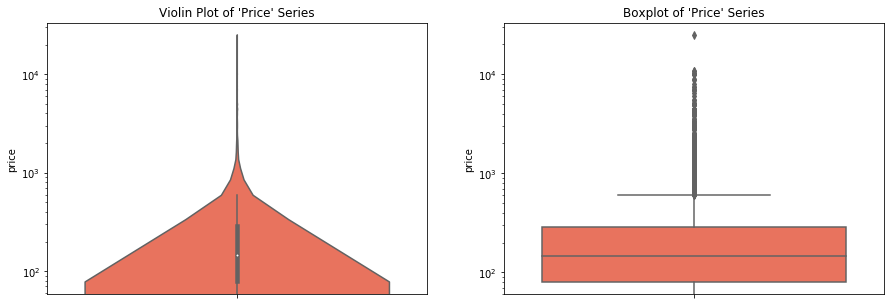

In [46]:
price = df["price"]

f, axes = plt.subplots(1, 2, figsize=(15,5))
ax = sns.violinplot(y=price, ax=axes[0], color="tomato")
ax.set(title="Violin Plot of 'Price' Series", yscale="log")

ax = sns.boxplot(y=price, ax=axes[1], color="tomato")
ax.set(title="Boxplot of 'Price' Series", yscale="log")

plt.show()

By sorting the series by price, we can see the most expensive listings.

In [47]:
sorted_df = df.sort_values("price", ascending=False)
display(sorted_df[["price"]].head(10))

,price
9634,24999.0
8455,10900.0
11142,10857.0
2166,10000.0
1871,10000.0
8607,10000.0
6165,10000.0
3104,10000.0
8251,10000.0
8253,9000.0


If entries are limited to $1,000 per night max, which is already a ludicrous rate, then we get a `price` that has better distribution. We see that rates above the 75th percentile are denoted appropriately as outliers.

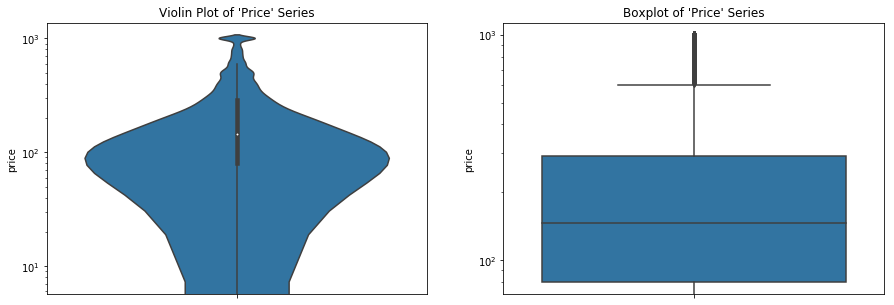

In [48]:
df.loc[df["price"] > 1000, "price"] = 1000

price = df["price"]

f, axes = plt.subplots(1, 2, figsize=(15,5))
ax = sns.violinplot(y=price, ax=axes[0])
ax.set(title="Violin Plot of 'Price' Series", yscale="log")

ax = sns.boxplot(y=price, ax=axes[1])
ax.set(title="Boxplot of 'Price' Series", yscale="log")

plt.show()

##  Data Story ##
### Austin, TX Map ###
The Airbnb `listings` dataset contains the global coordinate locations of every listing in Austin, TX. Likewise, the `crimes` dataset specifies the location of all the crimes that occurred (and were reported) in Austin, TX in the year 2018. These information aren't part of our final `df` dataset because we have opted to make use of zip codes to categorize the listings' locations. Still, we'll make use of these geographical points to explore our data further through the visualization of maps. We'll make use of the `austin_map` dataframe as the backdrop of our plots. This was derived from the Zip Codes GeoJSON taken from the City of Austin data portal.

In [49]:
austin_map = gpd.read_file("Zipcodes.geojson")
austin_map["zipcode"] = austin_map["zipcode"].astype(int)

print(type(austin_map))
display(austin_map.head())

<class 'geopandas.geodataframe.GeoDataFrame'>


,zipcode,name,number_of_records,objectid,zipcodes_id,geometry
0,78702,AUSTIN,45,51,45,"(POLYGON ((-97.69186838400699 30.248482149129,..."
1,78642,LIBERTY HILL,None,26,20,"(POLYGON ((-97.89359001287301 30.782117310707,..."
2,78752,AUSTIN,30,11,5,"(POLYGON ((-97.686347884619 30.332598550963, -..."
3,78747,AUSTIN,25,32,26,"(POLYGON ((-97.73618056605601 30.159870363356,..."
4,78653,MANOR,2,29,23,"(POLYGON ((-97.501494615524 30.477330039287, -..."


### Location and Price ###
We've simplified the classification of Airbnb listings into three types: *Apartment*, *House*, and *Other* – which is the category for the miscellaneous and even quirky listings including RV's, yurts, treehouses, and more.

Below is the plot of all the Austin, TX Airbnb listings categorized by type.

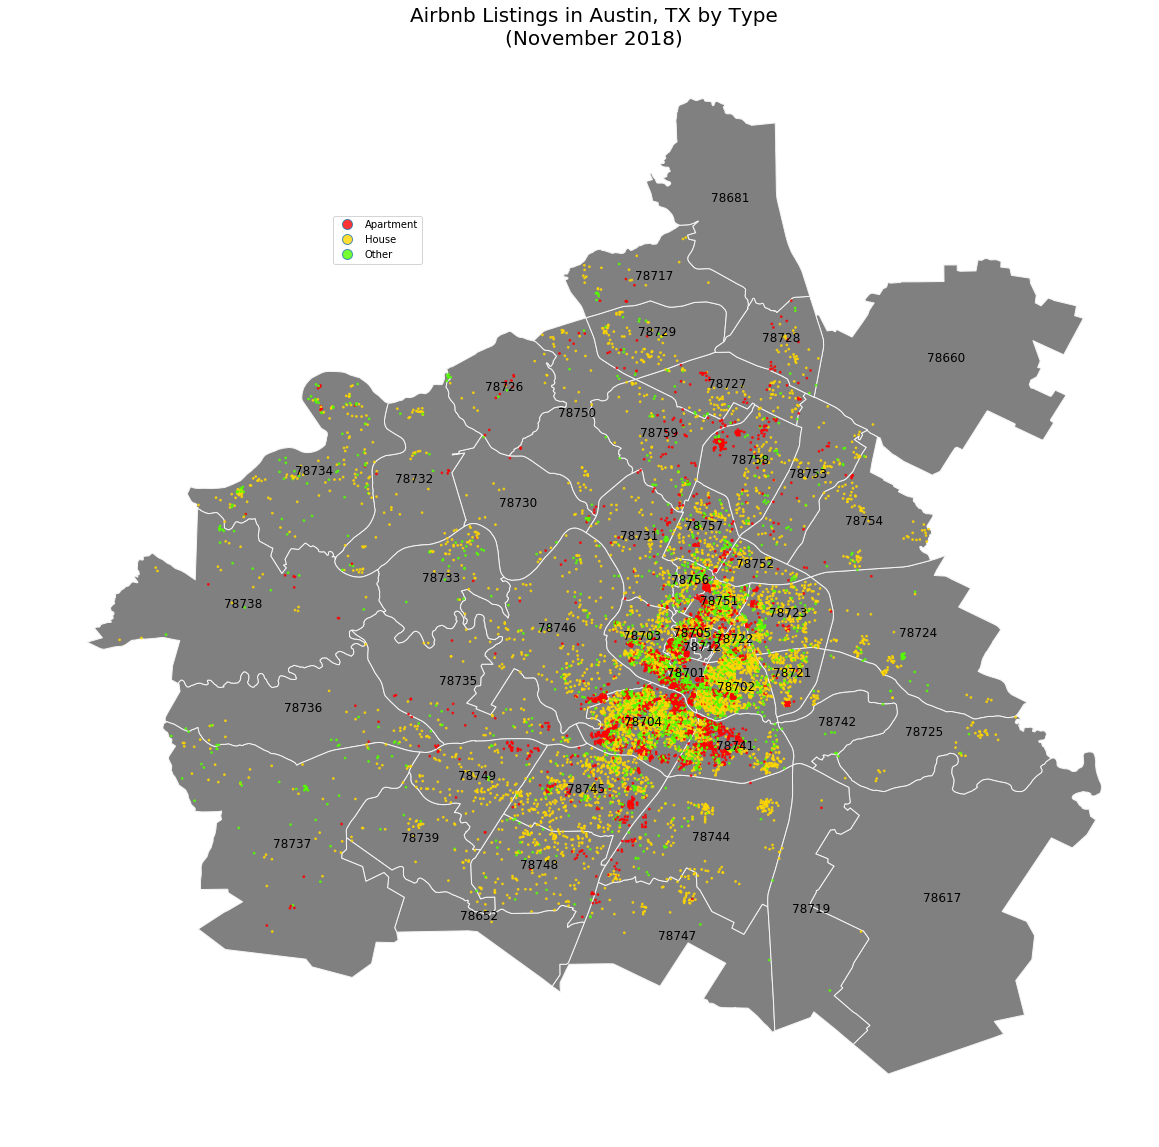

In [50]:
listings_df = pd.merge(listings[["id", "latitude", "longitude"]], \
                       df, how="right", on="id")
listings_df = listings_df[["zipcode", "id", "latitude", "longitude", \
                           "property_type (simple)"]]
listings_df["Point"] = listings_df.apply(lambda row: \
                                         Point(row["longitude"], \
                                               row["latitude"]), axis=1)
listings_df = gpd.GeoDataFrame(listings_df, geometry="Point")

geo_df = listings_df.groupby("zipcode").count()
geo_df = pd.merge(austin_map, geo_df, how="right", on="zipcode")
geo_df = geo_df.set_index("zipcode")

fig, ax = plt.subplots(figsize=(20,20))

base = geo_df.plot(color="grey", \
                   edgecolor="whitesmoke", ax=ax)
geo_df.apply(lambda x: ax.annotate(s=x.name, \
                                   xy=x.geometry.centroid.coords[0], \
                                   ha="center", fontweight="light", \
                                   fontsize=12, color="black"), axis=1)
base.axis("off")

listings_df.plot(ax=base, cmap="prism", marker="o", markersize=3, \
                 alpha=.8, column="property_type (simple)", \
                 categorical=True, legend=True)

legend = ax.get_legend()
legend.set_bbox_to_anchor((0.25, 0.75, 0.10, 0.10))

plt.title("Airbnb Listings in Austin, TX by Type\n(November 2018)", \
          fontdict={"fontsize":20})

plt.show()

From the figure, it was evident that listings are more concentrated within the inner zip codes, and listings begin dwindling and become more scattered as we go outward. We can draw different inferences from this – perhaps more listings suggest a more urban area. Or perhaps the farther out we are, the more regulations are put in place to ward off commercialization of suburban homes.

We can associate the cluster of listings with our main variable, *price*. Below is the plot of all the listings again but this time, on the backdrop of how expensive the zip code is in terms of *average* nightly Airbnb rate. The darker the green is, the more expensive, and the lighter the green is, the more affordable its listings are.

A good hypothesis is that prices should be cheaper in places that are more clustered because the competition should have lowered the price down. At the same time, the counterpoint could just be as likely: that more listings mean higher prices because this suggests more attractions and/or businesses are within close proximity.

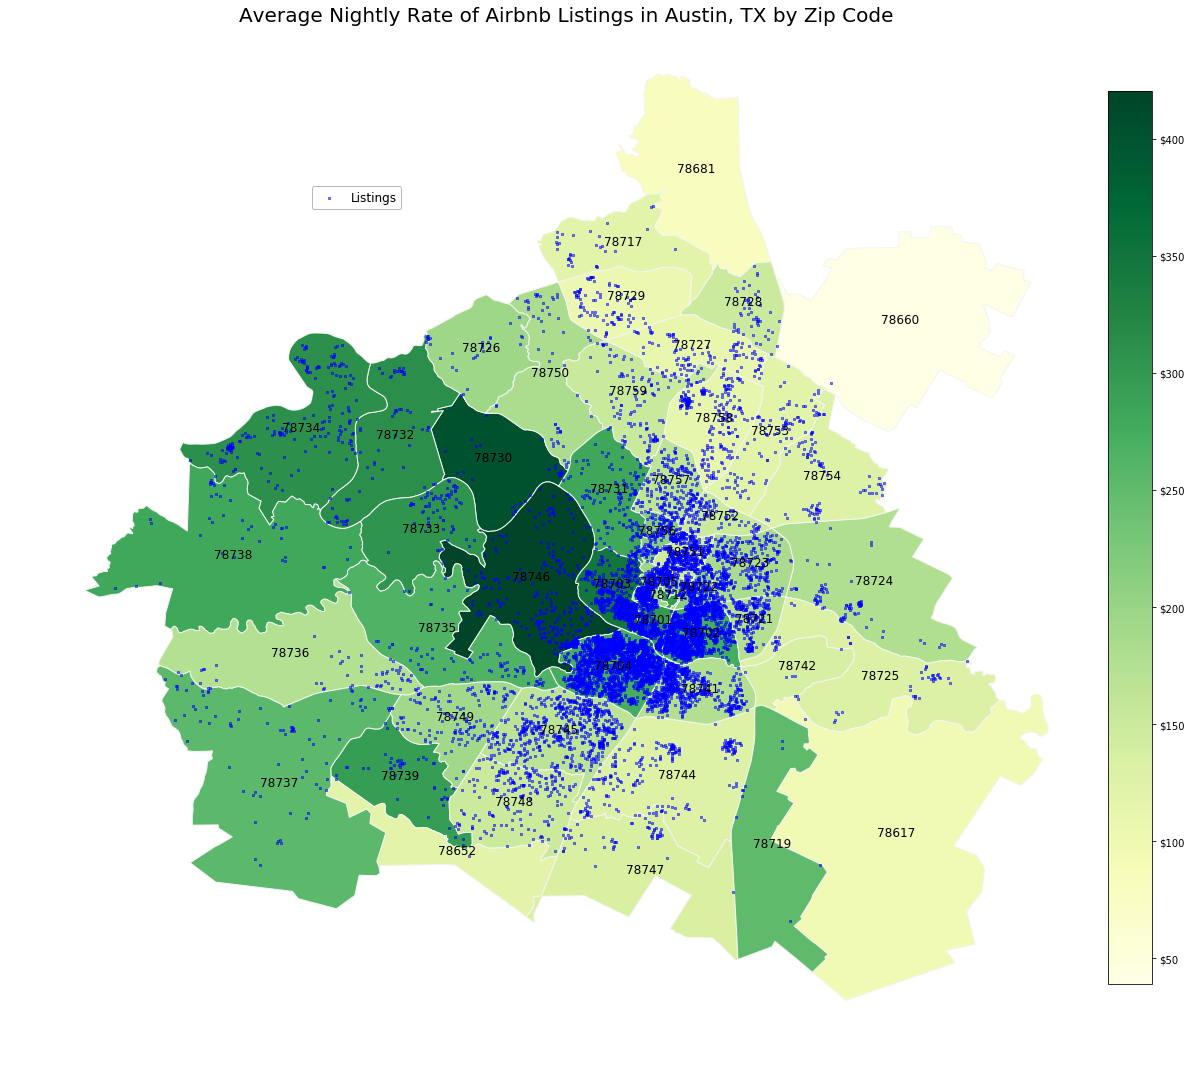

In [51]:
price_df = df.pivot_table(index="zipcode", values="price", aggfunc="mean")
price_df = pd.merge(austin_map, price_df, how="right", on="zipcode")
price_df = price_df.set_index("zipcode")

fig, ax = plt.subplots(figsize=(20,20))

base = price_df.plot(column="price", cmap="YlGn", \
                     edgecolor="whitesmoke", ax=ax)
price_df.apply(lambda x: ax.annotate(s=x.name, \
                                     xy=x.geometry.centroid.coords[0], \
                                     ha="center", fontweight="light", \
                                     fontsize=12, color="black"), axis=1)
base.axis("off")

min_price = price_df["price"].min()
max_price = price_df["price"].max()
gradient = plt.cm.ScalarMappable(cmap="YlGn", \
                                 norm=plt.Normalize(vmin=min_price, \
                                                    vmax=max_price))
gradient._A = []
cbar = fig.colorbar(gradient, fraction=0.04, pad=.01)

listings_df.plot(ax=base, color="blue", marker="s", markersize=1.5, \
                 alpha=.5, label="Listings")

cbar.ax.set_yticklabels(["$" + i.get_text() for i in cbar.ax.get_yticklabels()])

legend = plt.legend(facecolor="w", edgecolor="darkgray", fontsize=12)
legend.set_bbox_to_anchor((0.25, 0.75, 0.10, 0.10))

plt.title("Average Nightly Rate of Airbnb Listings in Austin, TX by Zip Code", \
          fontdict={"fontsize":20})

plt.show()

We see that, indeed, prices are higher in a zip code when there are a higher number of listings, though not exactly. Zip code 78730 is the second darkest area (suggesting the second priciest zip code) but there are only a handful of listings within it. And the opposite is true, in some cases, including 78757 which holds a lot of listings – most of which seem to be affordable according to their mean.

To get a better picture, below is the top 10 most expensive Airbnb zip codes (*in green*) and the top 10 places with the most Airbnb listings (*in blue*). If there is high correlation then we should see a lot of intersections (*in blue-green*).

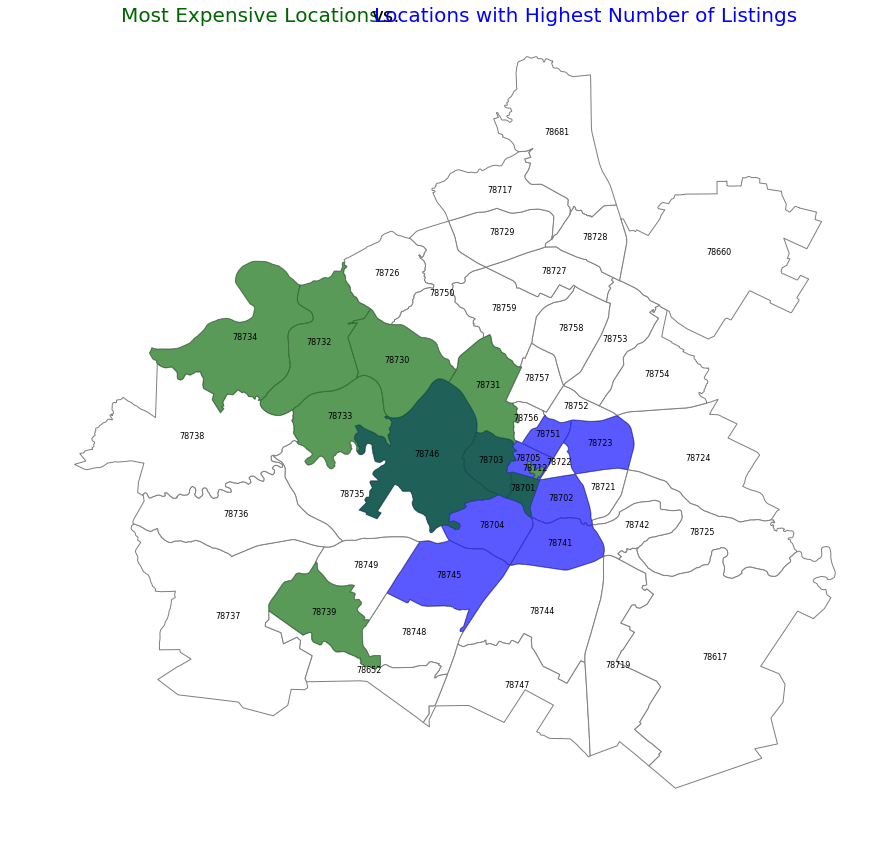

In [52]:
price_df = df.pivot_table(index="zipcode", values="price", aggfunc="mean")
price_df = pd.merge(austin_map, price_df, how="right", on="zipcode")
price_df = price_df.sort_values("price", ascending=False)
price_df = price_df[["zipcode", "geometry", "price"]].set_index("zipcode")

geo_df = listings_df.groupby("zipcode").count()
geo_df = pd.merge(austin_map, geo_df, how="right", on="zipcode")
geo_df = geo_df.sort_values("id", ascending=False)
geo_df = geo_df[["zipcode", "geometry", "id"]].set_index("zipcode")

fig, ax = plt.subplots(figsize=(15,15))

base = geo_df.plot(color="w", \
                   edgecolor="grey", ax=ax)
geo_df.apply(lambda x: ax.annotate(s=x.name, \
                                   xy=x.geometry.centroid.coords[0], \
                                   ha="center", fontweight="light", \
                                   fontsize=8, color="black"), axis=1)
base.axis("off")

geo_df[["geometry", "id"]][0:10].plot(color="blue", alpha=0.65, \
                                      ax=base)

price_df[["geometry", "price"]][0:10].plot(color="darkgreen", \
                                           alpha=0.65, ax=base)

fig.text(0.323, 0.870, "Most Expensive Locations", ha="center", \
         va="bottom", size=20,color="darkgreen")
fig.text(0.448, 0.870, "vs.", ha="center", va="bottom", size=20)
fig.text(0.634, 0.870, "Locations with Highest Number of Listings", \
         ha="center", va="bottom", size=20,color="blue")

plt.show()

There were three places that happen to be in *both* the top 10 most expensive zip codes and the top 10 most clustered. These are 78746, 78703, and 78701.

Another way to intuitively check correlation is to see the flipside of this: below is the top 10 least expensive zip codes and the top 10 locations that have the lowest number of listings.

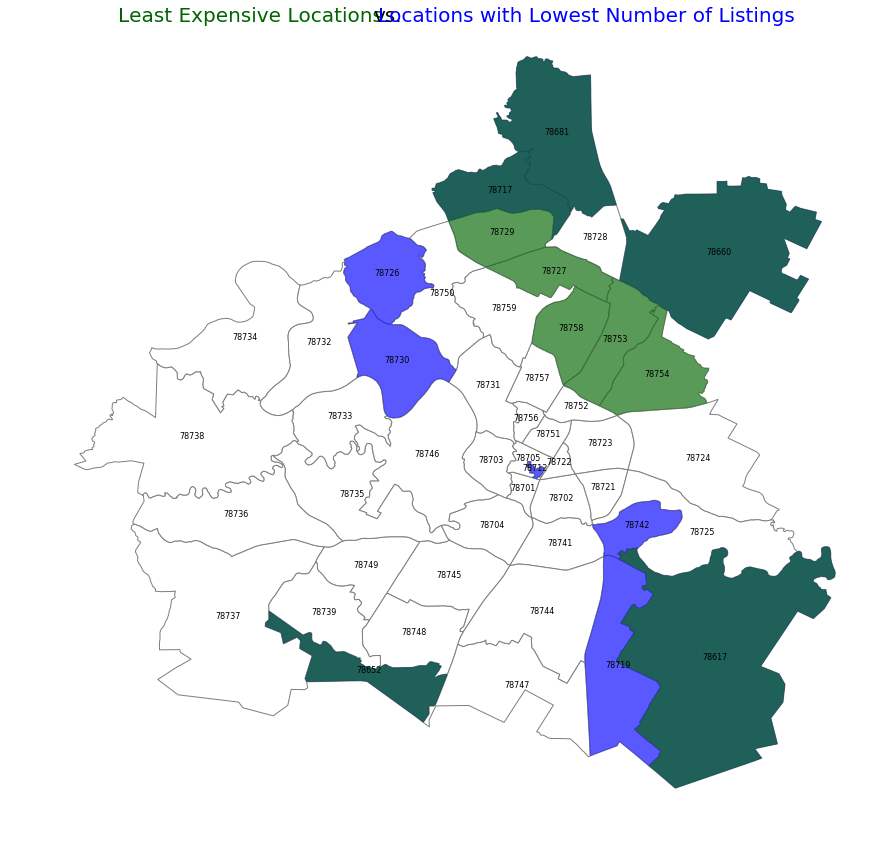

In [53]:
fig, ax = plt.subplots(figsize=(15,15))

base = geo_df.plot(color="w", \
                   edgecolor="grey", ax=ax)
geo_df.apply(lambda x: ax.annotate(s=x.name, \
                                   xy=x.geometry.centroid.coords[0], \
                                   ha="center", fontweight="light", \
                                   fontsize=8, color="black"), axis=1)
base.axis("off")

geo_df[["geometry", "id"]][-10:].plot(color="blue", alpha=0.65, \
                                      ax=base)

price_df[["geometry", "price"]][-10:].plot(color="darkgreen", \
                                           alpha=0.65, ax=base)

fig.text(0.323, 0.870, "Least Expensive Locations", ha="center", \
         va="bottom", size=20,color="darkgreen")
fig.text(0.450, 0.870, "vs.", ha="center", va="bottom", size=20)
fig.text(0.634, 0.870, "Locations with Lowest Number of Listings", \
         ha="center", va="bottom", size=20,color="blue")

plt.show()

This time they are more aligned, with *half* of the samples that intersect. These are 78681, 78717, 78660, 78617, 78652.

It is not clear-cut, but it's safe to say that in very general terms, price do have a relationship with the number of listings in a given area.

### Popularity and Price ###
We also have data on the number of reviews a listing has. We cannot say matter-of-factly that the more reviews a listing gets, the better rated it is. After all, a listing may have thousands of reviews but a majority could be *negative*. What a high number of reviews suggests instead is *popularity*. Popularity here means the same way as how an online retailer would describe a "best-seller". A popular listing just happens to have been more booked.

Below is the plot of the top 100 most reviewed listings in Austin, TX. A good hypothesis here is that the more reviews a listing has, the pricier it is. If so, this could be because popular listings tend to be more attractive. Or perhaps the more guests a host has had, the more experienced the host becomes in terms of hospitality.

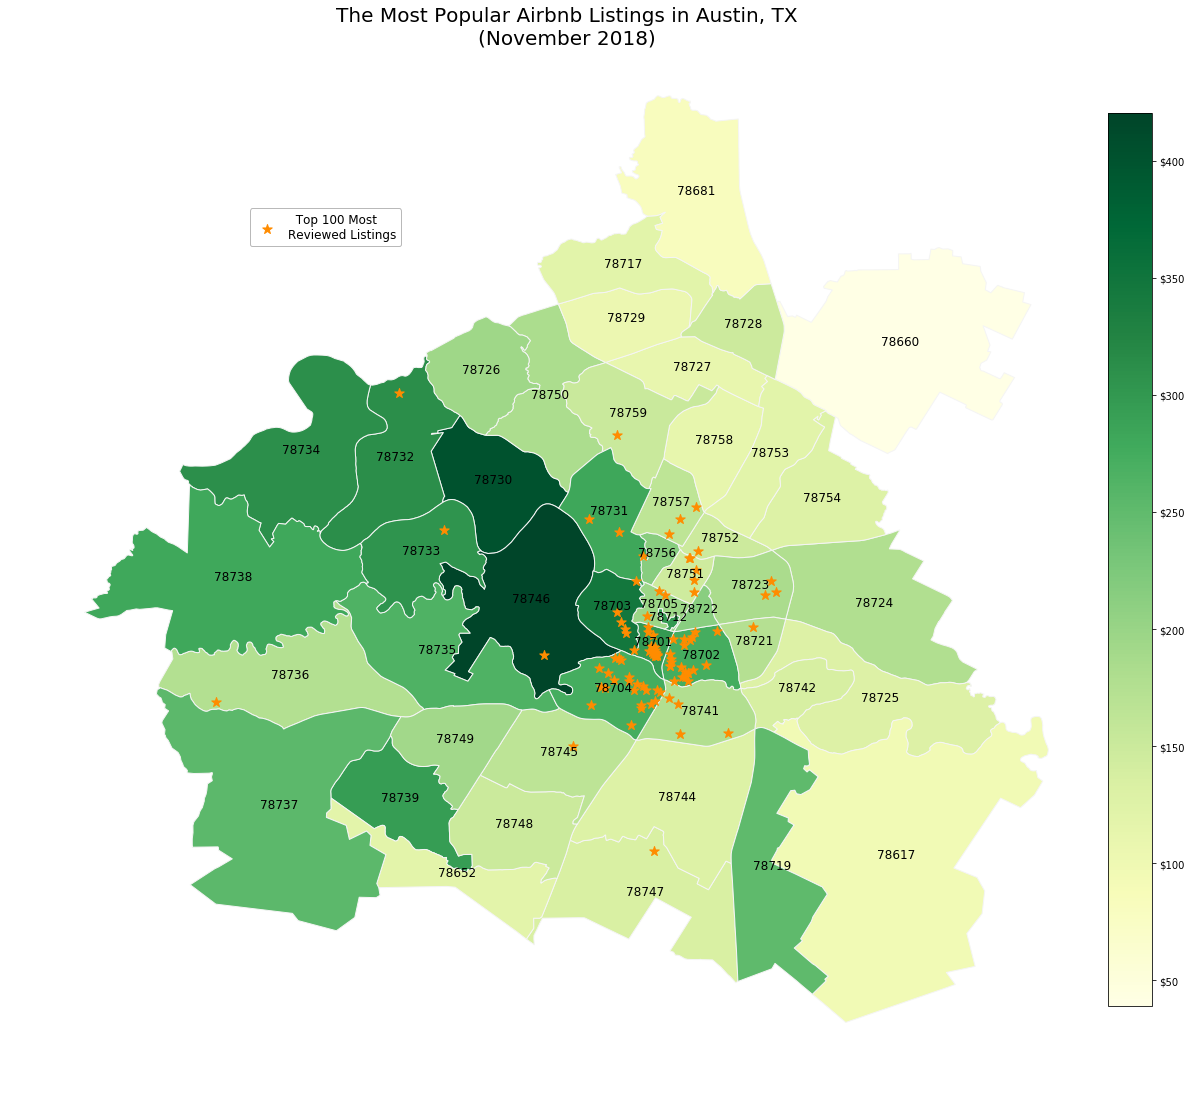

In [54]:
reviews_df = pd.merge(listings[["id", "latitude", "longitude"]], \
                      df, how="right", on="id")
reviews_df = reviews_df[["zipcode", "id", "latitude", "longitude", \
                         "number_of_reviews"]]
reviews_df["Point"] = reviews_df.apply(lambda row: \
                                       Point(row["longitude"], \
                                             row["latitude"]), axis=1)
reviews_df = gpd.GeoDataFrame(reviews_df, geometry="Point")
reviews_df = reviews_df.sort_values("number_of_reviews", ascending=False)
reviews_df = reviews_df.iloc[0:100]

price_df = df.pivot_table(index="zipcode", values="price", aggfunc="mean")
price_df = pd.merge(austin_map, price_df, how="right", on="zipcode")
price_df = price_df.set_index("zipcode")

fig, ax = plt.subplots(figsize=(20,20))

base = price_df.plot(column="price", cmap="YlGn", \
                   edgecolor="whitesmoke", ax=ax)
price_df.apply(lambda x: ax.annotate(s=x.name, \
                                     xy=x.geometry.centroid.coords[0], \
                                     ha="center", fontweight="light", \
                                     fontsize=12, color="black"), axis=1)
base.axis("off")

min_price = price_df["price"].min()
max_price = price_df["price"].max()
gradient = plt.cm.ScalarMappable(cmap="YlGn", \
                                 norm=plt.Normalize(vmin=min_price, \
                                                    vmax=max_price))
gradient._A = []
cbar = fig.colorbar(gradient, fraction=0.04, pad=.01)

reviews_df.plot(ax=base, color="darkorange", marker="*", markersize=100, \
                alpha=1, label="  Top 100 Most\nReviewed Listings")

cbar.ax.set_yticklabels(["$" + i.get_text() for i in cbar.ax.get_yticklabels()])

legend = plt.legend(facecolor="w", edgecolor="darkgray", fontsize=12)
legend.set_bbox_to_anchor((0.25, 0.75, 0.10, 0.10))

plt.title("The Most Popular Airbnb Listings in Austin, TX\n(November 2018)", \
          fontdict={"fontsize":20})

plt.show()

We do see that the most reviewed listings are clustered in areas that tend to be more expensive. But to test this deeper visually, we'll again plot the top 10 most expensive places (*in green*) along with the top 10 most reviewed places (*in orange*) to see if there are any intersections (*in gold*).

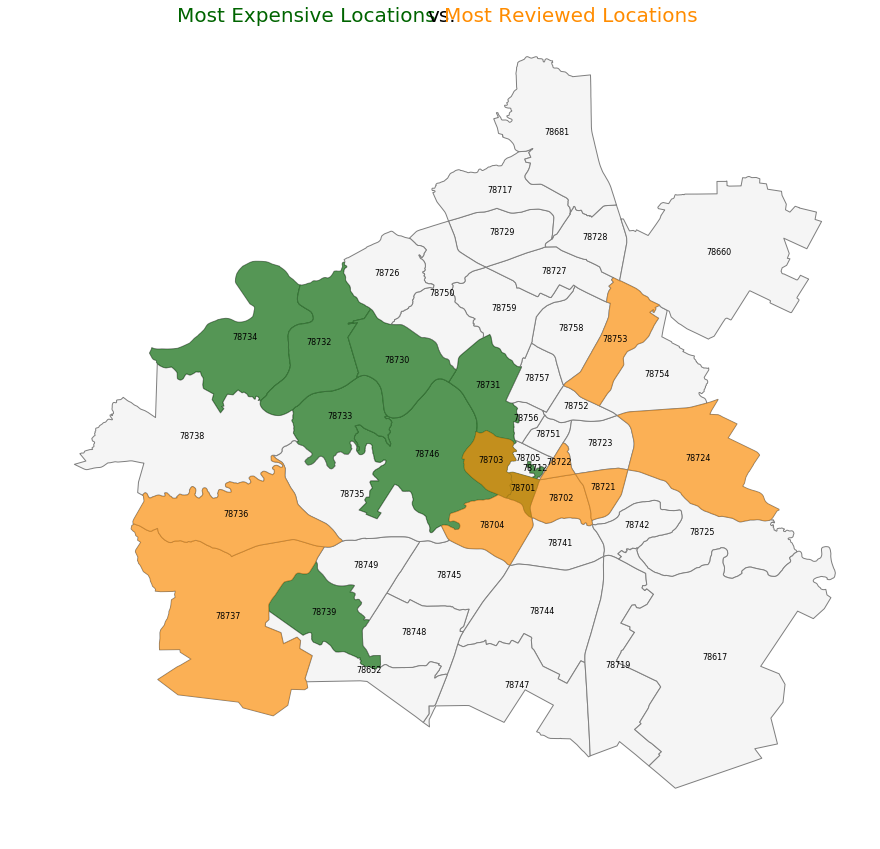

In [55]:
reviews_df = df.pivot_table(index="zipcode", \
                            values="number_of_reviews", aggfunc="mean")
reviews_df = pd.merge(austin_map, reviews_df, how="right", on="zipcode")
reviews_df = reviews_df.sort_values("number_of_reviews", ascending=False)
reviews_df = reviews_df[["zipcode", "geometry", \
                         "number_of_reviews"]].set_index("zipcode")

price_df = df.pivot_table(index="zipcode", \
                          values="price", aggfunc="mean")
price_df = pd.merge(austin_map, price_df, how="right", on="zipcode")
price_df = price_df.sort_values("price", ascending=False)
price_df = price_df[["zipcode", "geometry", "price"]].set_index("zipcode")

geo_df = listings_df.groupby("zipcode").count()
geo_df = pd.merge(austin_map, geo_df, how="right", on="zipcode")
geo_df = geo_df.sort_values("id", ascending=False)
geo_df = geo_df[["zipcode", "geometry", "id"]].set_index("zipcode")

fig, ax = plt.subplots(figsize=(15,15))

base = geo_df.plot(color="whitesmoke", \
                   edgecolor="grey", ax=ax)
geo_df.apply(lambda x: ax.annotate(s=x.name, \
                                   xy=x.geometry.centroid.coords[0], \
                                   ha="center", fontweight="light", \
                                   fontsize=8, color="black"), axis=1)
base.axis("off")

price_df[["geometry", "price"]][0:10].plot(color="darkgreen", alpha=0.65, \
                                           ax=base)

reviews_df[["geometry", "number_of_reviews"]][0:10].plot(color="darkorange", \
                                                         alpha=0.65, ax=base)

fig.text(0.375, 0.870, "Most Expensive Locations", ha="center", \
         va="bottom", size=20,color="darkgreen")
fig.text(0.500, 0.870, "vs.", ha="center", va="bottom", size=20)
fig.text(0.620, 0.870, "Most Reviewed Locations", ha="center", \
         va="bottom", size=20,color="darkorange")

plt.show()

We see that only two of the most expensive zip codes happen to also be the places where the most reviewed listings are. These are 78703 and 78701.

Again, we'll do the opposite and see if the top ten least expensive locations coincide with the top ten least reviewed locations.

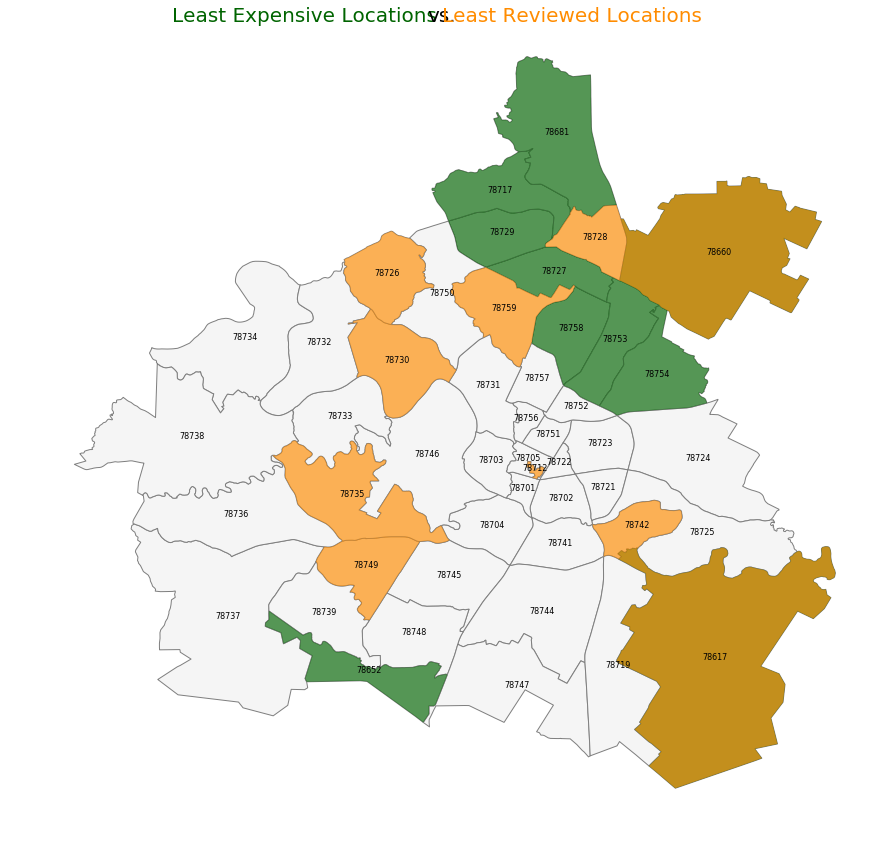

In [56]:
fig, ax = plt.subplots(figsize=(15,15))

base = geo_df.plot(color="whitesmoke", \
                   edgecolor="grey", ax=ax)
geo_df.apply(lambda x: ax.annotate(s=x.name, \
                                   xy=x.geometry.centroid.coords[0], \
                                   ha="center", fontweight="light", \
                                   fontsize=8, color="black"), axis=1)
base.axis("off")

price_df[["geometry", "price"]][-10:].plot(color="darkgreen", alpha=0.65, \
                                           ax=base)

reviews_df[["geometry", "number_of_reviews"]][-10:].plot(color="darkorange", \
                                                         alpha=0.65, ax=base)

fig.text(0.373, 0.870, "Least Expensive Locations", ha="center", \
         va="bottom", size=20,color="darkgreen")
fig.text(0.500, 0.870, "vs.", ha="center", va="bottom", size=20)
fig.text(0.621, 0.870, "Least Reviewed Locations", ha="center", \
         va="bottom", size=20,color="darkorange")

plt.show()

We learn that there are also only two zip codes that happen to be the least expensive and the least reviewed. These are 78660 and 78617.

From the above plots, it can be said that there is a relationship between the number of reviews of a listings and its price – though it's quite weak.

### Crimes and Price ###
Below is the total number of crimes that occurred in every Austin, TX zip code during 2018. This was plotted after aggregating all the crimes in the `crimes` dataset in only the zip codes that are also present in our `listings` dataset.

Since high crime just happens to be an unfortunate byprodut of a bustling city, then a good hypothesis would be: more crime indicates an expensive zip code. Note that we are keeping it simple and are looking at the total number of crimes in *absolute* terms, as a count of how many were reported. We are not looking at *per capita* crime since there are no population data in our datasets.

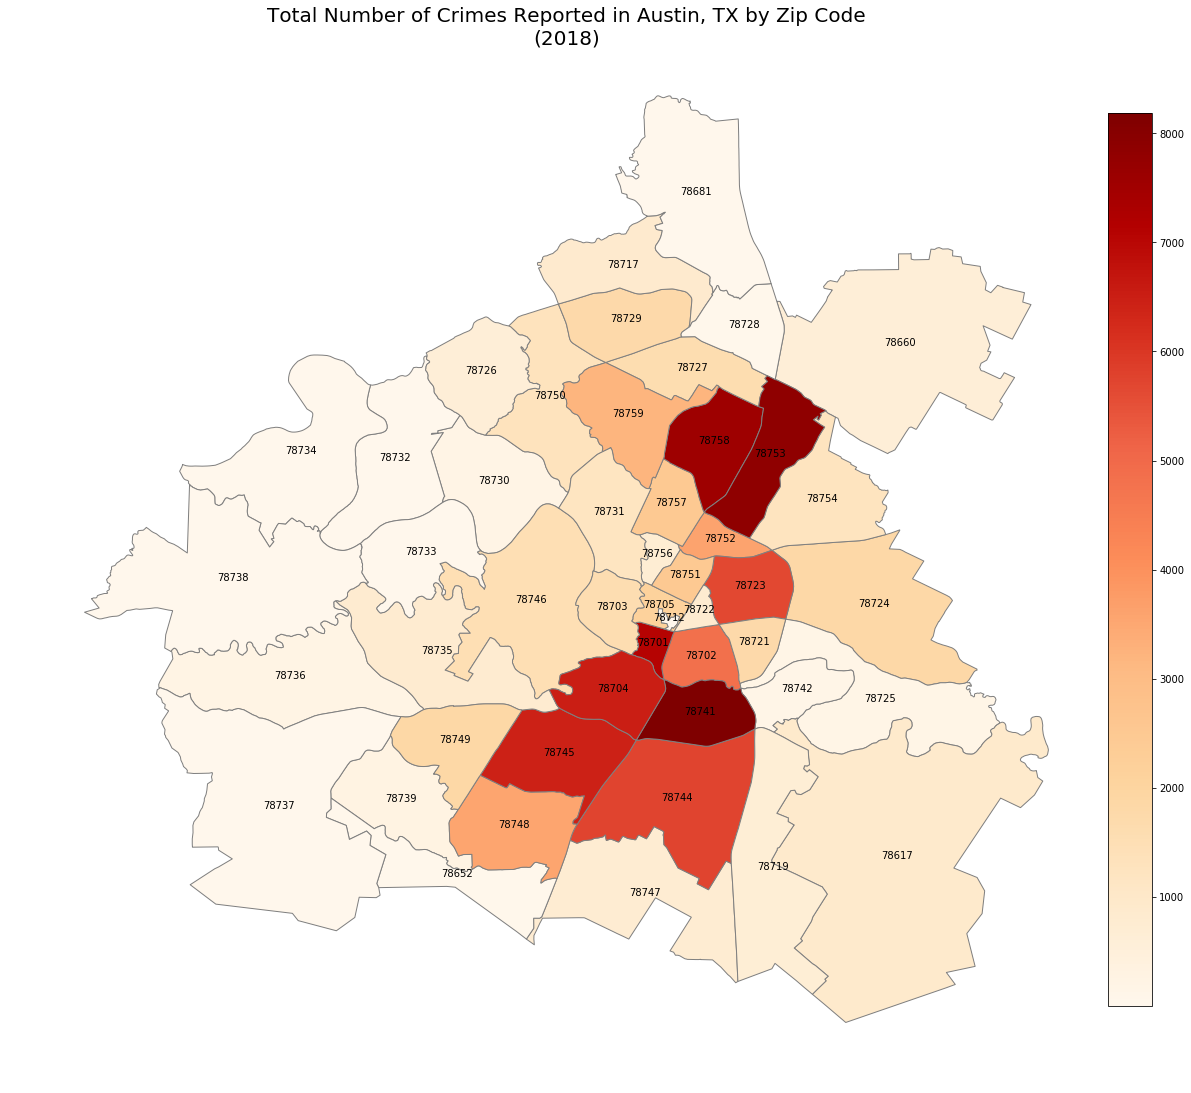

In [57]:
crimes_df = df.drop_duplicates(subset=["zipcode", "Total No. of Crimes"])
crimes_df = crimes_df[["zipcode", "Total No. of Crimes"]]
crimes_df = pd.merge(austin_map, crimes_df, how="right", on="zipcode")
crimes_df = crimes_df.set_index("zipcode")

fig, ax = plt.subplots(figsize=(20,20))

ax = crimes_df.plot(column="Total No. of Crimes", cmap="OrRd", \
                    edgecolor="grey", ax=ax)
crimes_df.apply(lambda x: ax.annotate(s=x.name, \
                                      xy=x.geometry.centroid.coords[0], \
                                      ha="center", fontweight="ultralight", \
                                      color="black"), axis=1)
ax.axis("off")

min_crimes = crimes_df["Total No. of Crimes"].min()
max_crimes = crimes_df["Total No. of Crimes"].max()

gradient = plt.cm.ScalarMappable(cmap="OrRd", \
                            norm=plt.Normalize(vmin=min_crimes, \
                                               vmax=max_crimes))
gradient._A = []
plt.colorbar(gradient, fraction=0.04, pad=.01)

plt.title("Total Number of Crimes Reported in Austin, TX by Zip Code\n(2018)", \
          fontdict={"fontsize":20})

plt.show()

We can test the relationshop of high crime and high price by plotting the top 10 most expensive Airbnb zip codes (*in green*) along with the top 10 locations with the most crime (*in red*). We see that there is only one intersection, 78701, in maroon.

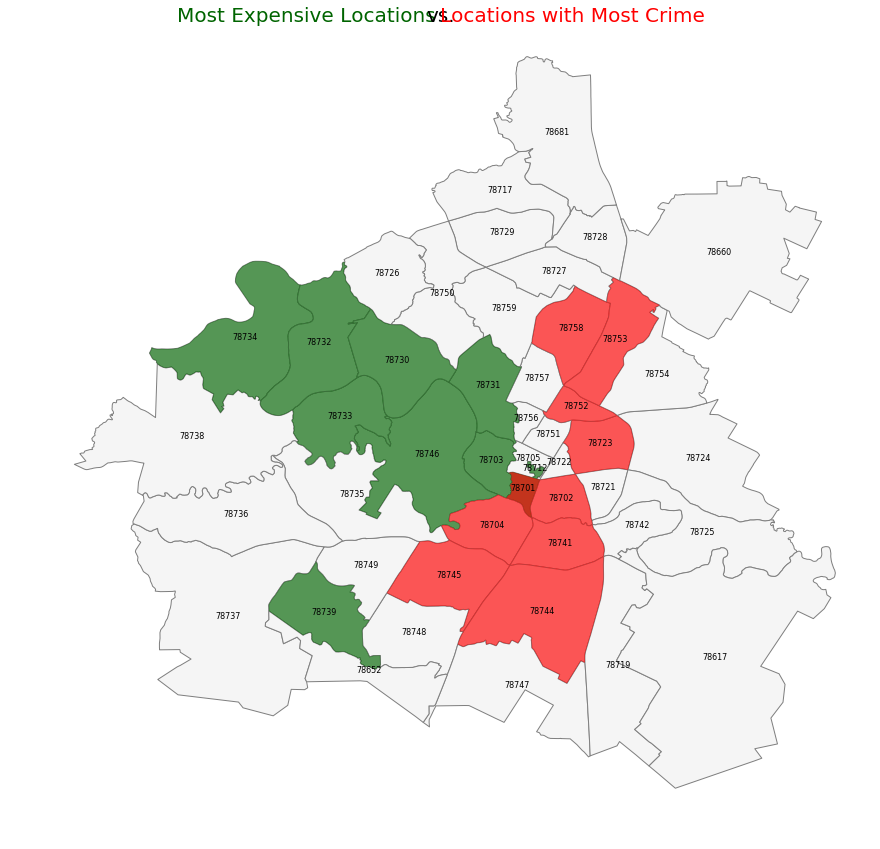

In [58]:
crimes_df = df.drop_duplicates(subset=["zipcode", "Total No. of Crimes"])
crimes_df = crimes_df[["zipcode", "Total No. of Crimes"]]
crimes_df = pd.merge(austin_map, crimes_df, how="right", on="zipcode")
crimes_df = crimes_df.sort_values("Total No. of Crimes", ascending=False)
crimes_df = crimes_df[["zipcode", "geometry", \
                       "Total No. of Crimes"]].set_index("zipcode")

price_df = df.pivot_table(index="zipcode", values="price", aggfunc="mean")
price_df = pd.merge(austin_map, price_df, how="right", on="zipcode")
price_df = price_df.sort_values("price", ascending=False)
price_df = price_df[["zipcode", "geometry", "price"]].set_index("zipcode")

geo_df = listings_df.groupby("zipcode").count()
geo_df = pd.merge(austin_map, geo_df, how="right", on="zipcode")
geo_df = geo_df.sort_values("id", ascending=False)
geo_df = geo_df[["zipcode", "geometry", "id"]].set_index("zipcode")

fig, ax = plt.subplots(figsize=(15,15))

base = geo_df.plot(color="whitesmoke", \
                   edgecolor="grey", ax=ax)
geo_df.apply(lambda x: ax.annotate(s=x.name, \
                                   xy=x.geometry.centroid.coords[0], \
                                   ha="center", fontweight="light",
                                   fontsize=8, color="black"), axis=1)
base.axis("off")

price_df[["geometry", "price"]][0:10].plot(color="darkgreen", \
                                           alpha=0.65, ax=base)

crimes_df[["geometry", "Total No. of Crimes"]][0:10].plot(color="red", \
                                                          alpha=0.65, ax=base)

fig.text(0.375, 0.870, "Most Expensive Locations", ha="center", \
         va="bottom", size=20,color="darkgreen")
fig.text(0.499, 0.870, "vs.", ha="center", va="bottom", size=20)
fig.text(0.621, 0.870, "Locations with Most Crime", ha="center", \
         va="bottom", size=20,color="red")

plt.show()

The opposite can also test the relationship: this is by plotting the top ten with the least crimes against the top ten least expensive places. Again, there isn't much in terms of intersection, with only two zip codes that coincide: 78681 and 78652.

This then tells us that high crime doesn't necessarily mean higher price. Perhaps because crime may not be a concern for a guest that has already decided to book a place in Austin, TX, especially if the crime rate isn't dire enough to stave off tourism.

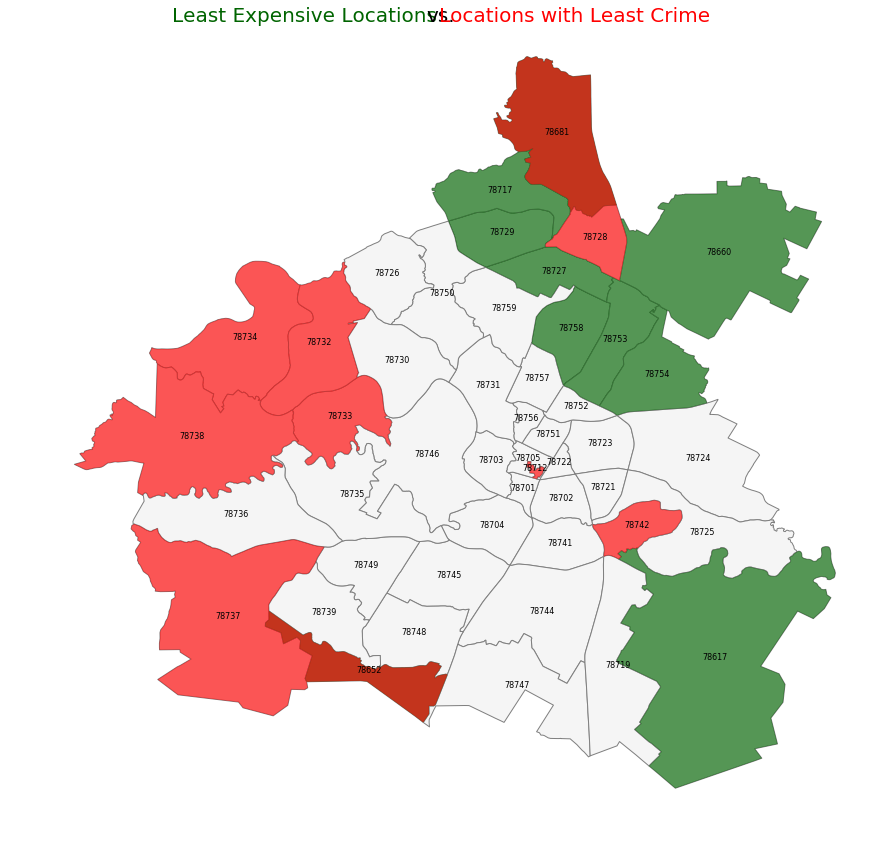

In [59]:
fig, ax = plt.subplots(figsize=(15,15))

base = geo_df.plot(color="whitesmoke", \
                   edgecolor="grey", ax=ax)
geo_df.apply(lambda x: ax.annotate(s=x.name, \
                                   xy=x.geometry.centroid.coords[0], \
                                   ha="center", fontweight="light", \
                                   fontsize=8, color="black"), axis=1)
base.axis("off")

price_df[["geometry", "price"]][-10:].plot(color="darkgreen", alpha=0.65, \
                                           ax=base)

crimes_df[["geometry", "Total No. of Crimes"]][-10:].plot(color="red", \
                                                          alpha=0.65, ax=base)

fig.text(0.373, 0.870, "Least Expensive Locations", ha="center", \
         va="bottom", size=20,color="darkgreen")
fig.text(0.499, 0.870, "vs.", ha="center", va="bottom", size=20)
fig.text(0.623, 0.870, "Locations with Least Crime", ha="center", \
         va="bottom", size=20,color="red")

plt.show()

### Distribution of Categorical Data ###
A lot of the features of our final `df` dataframe are discrete with minimal range of values. If we group the distribution of price per a categorical feature's range of values and plot them in a boxplot, we would be able to visually *infer* if the feature would be able to predict our dependent variable, *price*.

The figures below characterize the listing in terms of its host. As we see, `host_identity_verified` shows almost no variability across its two categories and that `1` is only *slightly* different from `0` in terms of spread. That tells us that this is not a good predictor for our model.

On the other hand, `host_is_superhost` is more characterizing as there is a noticable shift.

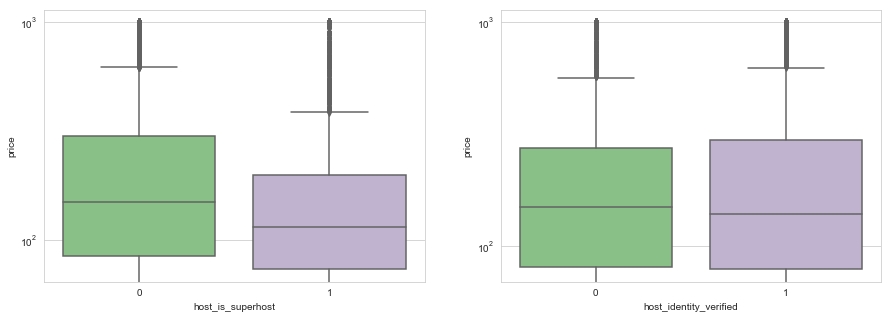

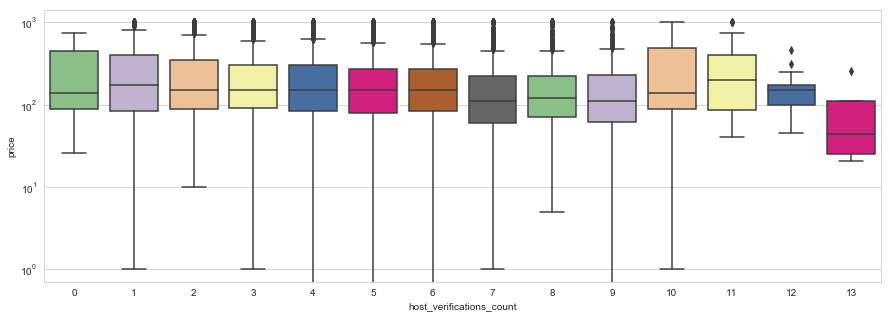

In [60]:
sns.set_style("whitegrid")

f, axes = plt.subplots(1, 2, figsize=(15,5))
ax = sns.boxplot(data=df, x="host_is_superhost", y="price", \
                 palette="Accent", ax=axes[0])
ax.set(yscale="log")
ax = sns.boxplot(data=df, x="host_identity_verified", y="price", \
                 palette="Accent", ax=axes[1])
ax.set(yscale="log")
plt.show()

f, axes = plt.subplots(figsize=(15,5))
ax = sns.boxplot(data=df, x="host_verifications_count", y="price", \
                 palette="Accent")
ax.set(yscale="log")
plt.show()

The next set of features look at the categorical columns of listings in terms of their nature. The `room_type` is a very good candidate for our model because of how distinct each of its value is. It is immediately clear from the figure that entire houses are more affordable than private rooms, and even more so than with shared rooms.

The `cancellation_policy` boxplots show us that the most expensive places have the strictest booking policies.

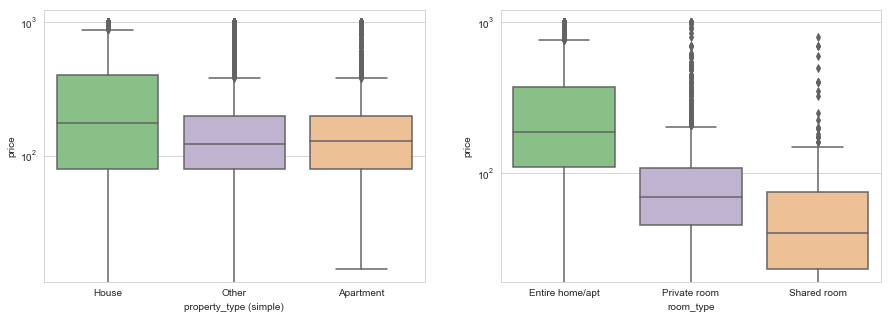

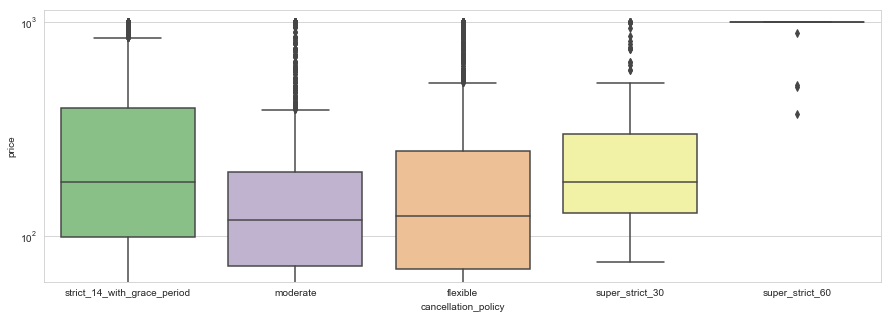

In [61]:
sns.set_style("whitegrid")

f, axes = plt.subplots(1, 2, figsize=(15,5))
ax = sns.boxplot(data=df, x="property_type (simple)", y="price", \
                 palette="Accent", ax=axes[0])
ax.set(yscale="log")
ax = sns.boxplot(data=df, x="room_type", y="price", \
                 palette="Accent", ax=axes[1])
ax.set(yscale="log")
plt.show()

f, axes = plt.subplots(figsize=(15,5))
ax = sns.boxplot(data=df, x="cancellation_policy", y="price", \
                 palette="Accent")
ax.set(yscale="log")
plt.show()

The next batch of features are the categories that were generated from the listings' `amenities`. Here, it makes it evident that `Family-friendly` places tend to be costlier than those that are not (or those that do not specify that they are). Perhaps these listings are able to accommodate more headcount or perhaps these tend to be in quieter neighborhoods and hence are generally more expensive.

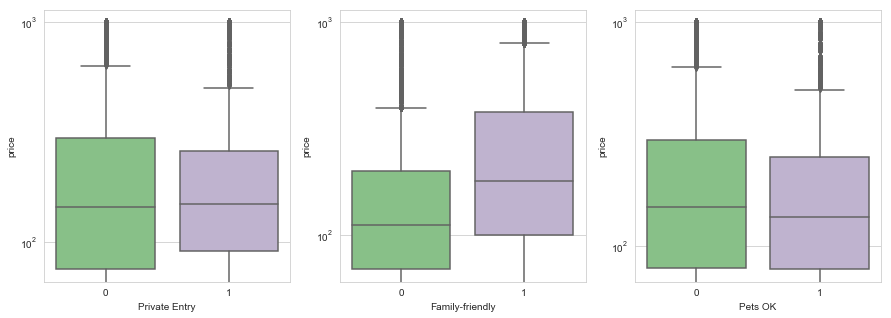

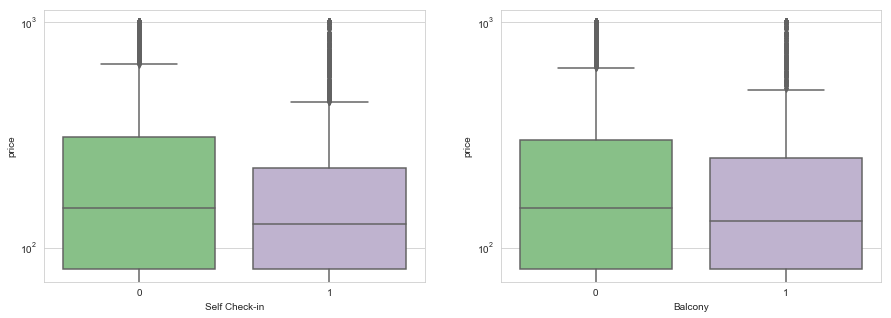

In [62]:
sns.set_style("whitegrid")

f, axes = plt.subplots(1, 3, figsize=(15,5))
ax = sns.boxplot(data=df, x="Private Entry", y="price", \
                 palette="Accent", ax=axes[0])
ax.set(yscale="log")
ax = sns.boxplot(data=df, x="Family-friendly", y="price", \
                 palette="Accent", ax=axes[1])
ax.set(yscale="log")
ax = sns.boxplot(data=df, x="Pets OK", y="price", \
                 palette="Accent", ax=axes[2])
ax.set(yscale="log")
plt.show()

f, axes = plt.subplots(1, 2, figsize=(15,5))
ax = sns.boxplot(data=df, x="Self Check-in", y="price", \
                 palette="Accent", ax=axes[0])
ax.set(yscale="log")
ax = sns.boxplot(data=df, x="Balcony", y="price", \
                 palette="Accent", ax=axes[1])
ax.set(yscale="log")
plt.show()

The `minimum nights` feature also shows distinction per classification. It's quite intuitive to assume that places that allow shorter-term stays would be pricier (like in the terms of lease in most apartments), but somehow this is not the case here. The pricing in terms of this feature is more varied.

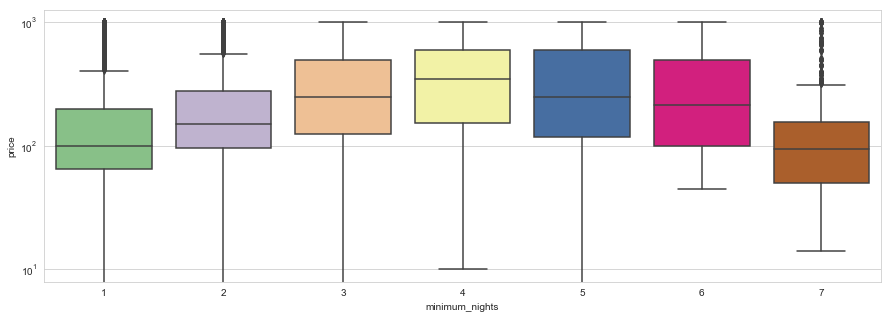

In [63]:
sns.set_style("whitegrid")

f, axes = plt.subplots(figsize=(15,5))
ax = sns.boxplot(data=df, x="minimum_nights", y="price", \
                 palette="Accent")
ax.set(yscale="log")
plt.show()

The `accommodates` and the `guests_included` features both give us a sense of how large a listing is. For the former, a smaller listing would only be able to accommodate fewer people and therefore the lower the number is, the cheaper. For the latter, if more headcount can be accommodated without extra charge, then that suggests these extra people are already *priced in* on the nightly rate, and are therefore more expensive.

These takeaways can be inferred from the plots below.

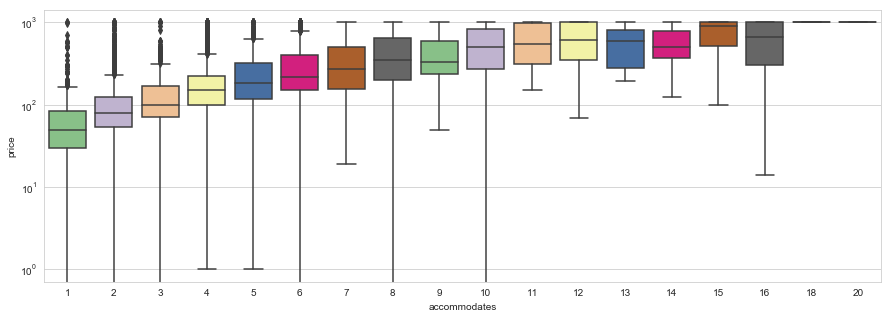

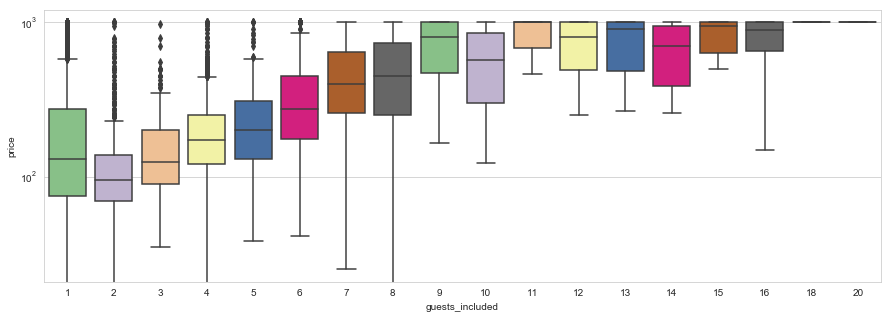

In [64]:
sns.set_style("whitegrid")

f, axes = plt.subplots(1, 1, figsize=(15,5))
ax = sns.boxplot(data=df, x="accommodates", y="price", \
                 palette="Accent")
ax.set(yscale="log")
plt.show()

f, axes = plt.subplots(1, 1, figsize=(15,5))
ax = sns.boxplot(data=df, x="guests_included", y="price", \
                 palette="Accent")
ax.set(yscale="log")
plt.show()